# Investigate lineage-specific differences in mutations from H3N2 evolution

## Overview

We performed a deep mutational scan of the **H3 hemagglutinin from the Perth/2009 (H3N2) strain** to measure the effects of mutations on viral growth in cell culture. An overview of the experimental setup, analysis of the deep sequencing data, and estimation of preferences are described in the `dms_analysis.ipynb` Jupyter notebook.

In this analysis, we will use these experimental measurements to examine if our experimental measurements can help us distinguish between trunk and side branch lineages of human H3N2 influenza virus.

For this analysis, we will be using an H3N2 phylogeny from 1968-2017, as prepared by the `fauna` and `augur` pipelines from `nextstrain`, as well as the across-replicate averaged and re-scaled amino-acid preferences.

## Goals

In this analysis, we will try to accomplish the following:
1. Quantify the effects of trunk and side branch mutations using the Perth/2009 H3 HA amino-acid preferences
2. Quantify the effects of trunk and side branch mutations using the WSN/1933 H1 HA amino-acid preferences
3. Compare the `sequence preference` of trunk and side branch nodes
4. Investigate the effects of mutations and the sequence preference of trunk and side branch mutations at epitope and non-epitope sites
5. Look at sequence preference of nodes that follow the split of Perth/2009 off the trunk

## Import modules, define directories

In [1]:
import os
import re
import glob
import itertools
import random
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import seaborn as sns
import collections
import statsmodels.stats.multitest

import Bio
import Bio.Phylo
import pickle
import gzip
import io
import json
import urllib
import codecs
from scipy.interpolate import splev, splrep
from collections import defaultdict

import dms_tools2
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import warnings
warnings.simplefilter('ignore') # don't print warnings to avoid clutter in notebook
from IPython.display import display, HTML, Markdown
# from pymodules.utils import * # custom modules for this analysis

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

inputdir = './data/'
resultsdir = './results/'
prefsdir = os.path.join(resultsdir, 'preferences/')
renumberedprefsdir = os.path.join(resultsdir, 'H3renumberedprefs/')
plotsdir = os.path.join(resultsdir, 'plots/')

Using dms_tools2 version 2.2.0


## Define the preferences file to be used for this analysis

We will be using the across-replicate averaged and re-scaled preferences in H3 numbering for this analysis.

In [2]:
rescaledavgprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs_rescaled.csv')

## Read in H3N2 phylogenetic tree
Here we will use the complete H3N2 phylogeny from 1968-2017, which we prepared by using the `nextstrain` pipeline (specifically `fauna` and `augur`). 
Briefly, we downloaded all full-length H3 human H3N2 sequences from the Influenza Virus Resource, subsampled the sequences, and built a phylogenetic tree using maximum-likelihood ancestral state reconstruction.

We will use this phylogeny to collect trunk and side branch mutations and calculate the mutational effects on both sets of branches.

The [tree file](./data/flu_h3n2_1968_6v_tree.json.gz) is in a zipped `JSON` file format in the [./data/](./data/) directory.
First, we must define a function to convert a `JSON` dictionary into a `Bio.Phylo` tree.

In [3]:
def json_to_tree(json_dict):
    """Returns a Bio.Phylo tree corresponding to the given JSON dictionary exported
    by `tree_to_json`.
    >>> import json
    >>> json_fh = open("tests/data/flu_h3n2_ha_3y_tree.json", "r")
    >>> json_dict = json.load(json_fh)
    >>> tree = json_to_tree(json_dict)
    >>> tree.name
    u'NODE_0002020'
    >>> len(tree.clades)
    2
    >>> tree.clades[0].name
    u'NODE_0001489'
    >>> hasattr(tree, "attr")
    True
    >>> "dTiter" in tree.attr
    True
    """
    node = Bio.Phylo.Newick.Clade()
    node.name = json_dict["strain"]

    if "children" in json_dict:
        # Recursively add children to the current node.
        node.clades = [json_to_tree(child) for child in json_dict["children"]]

    # Assign all non-children attributes.
    for attr, value in json_dict.items():
        if attr != "children":
            setattr(node, attr, value)

    return node

In [4]:
# Load tree JSON file used by auspice. These data are compressed.
# Decompress JSON data and load into a Python dict.
reader = codecs.getreader("utf-8")
with gzip.open("{0}/flu_h3n2_ha_1968_2018_6v_tree.json.gz".format(inputdir), "rb") as json_uncompressed_fh:
    json_tree = json.load(reader(json_uncompressed_fh))
    
# Load frequencies JSON file used by auspice. These data are compressed.
# Decompress JSON data and load into a Python dict.
with gzip.open("{0}/flu_h3n2_ha_1968_2018_6v_frequencies.json.gz".format(inputdir), "rb") as json_uncompressed_fh:
    frequencies = json.load(reader(json_uncompressed_fh))

In [5]:
# Convert JSON tree layout to a Biopython Clade instance.
tree = json_to_tree(json_tree)

### Filter nodes by stop codons
We next need to remove nodes from the tree that contain stop codon mutations because these nodes will have incorrect sequence preference values.

In [6]:
def has_stop_codon(node):
    return "X" in node.aa_sequence or ("*" in node.aa_sequence and not node.aa_sequence.endswith("*"))

In [7]:
len(list(tree.find_clades()))

4026

In [8]:
pruned_nodes = []
for node in tree.find_clades():
    children = []
    for child in node.clades:
        if has_stop_codon(child):
            pruned_nodes.extend(list(child.find_clades()))
        else:
            children.append(child)
    
    node.clades = children

In [9]:
len(list(tree.find_clades()))

4011

In [10]:
for node in pruned_nodes:
    print(node.name)

A/Athens/23/1997
A/Malaysia/12550/1997
A/Singapore/16/2002
A/NorthDakota/1e/2004
NODE_0001283
A/Thailand/558/2006
NODE_0001284
A/Ryazan/10/2006
NODE_0001285
A/Khabarovsk/49/2006
A/Moscow/4/2006
A/Kaliningrad/31/2006
A/Bahia/12/2007
A/Texas/33/2007
A/HeilongjiangQiqiharJianhua/1496/2009


## Annotate parents

In [11]:
# Find the DMS strain.
dms_strain = [node for node in tree.find_clades() if node.strain == "A/Perth/16/2009"][0]

In [12]:
# Biopython's trees don't store links to node parents, so we need to build
# a map of each node to its parent.
# Code from the Bio.Phylo cookbook: http://biopython.org/wiki/Phylo_cookbook
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order='level'):
        for child in clade:
            parents[child] = clade
    return parents

parents_by_node = all_parents(tree)

In [13]:
# Next, annotate each node with its parent.
parents_by_node = all_parents(tree)
for node in tree.find_clades():
    if node == tree.root:
        node.parent = None
    else:
        node.parent = parents_by_node[node]

## Filter out outlier nodes

In [14]:
nodes_df = []
for node in tree.find_clades():
    nodes_df.append({
        "name": node.name,
        "distance_from_parent": node.parent is not None and (node.attr["num_date"] - node.parent.attr["num_date"]) or 0.0
    })

nodes_df = pd.DataFrame(nodes_df)

In [15]:
nodes_df[nodes_df["distance_from_parent"] == nodes_df["distance_from_parent"].max()]

,distance_from_parent,name
568,15.429843,A/Indiana/127/2012


In [16]:
sorted(nodes_df["distance_from_parent"].values)[-5:]

[4.4578498087614662,
 5.0236767192673142,
 5.1786785373385555,
 5.554784632574183,
 15.429842573579663]

In [17]:
outlier_nodes = set(nodes_df[nodes_df["distance_from_parent"] > 5]["name"].values.tolist())

In [18]:
muts_by_node = []
for node in tree.get_terminals():
    muts = 0
    if hasattr(node, "aa_muts"):
        for gene, mutations in node.aa_muts.items():
            muts += len(mutations)
            
    muts_by_node.append({"node": node.name, "muts": muts})

muts_by_node_df = pd.DataFrame(muts_by_node)

In [19]:
muts_threshold = muts_by_node_df["muts"].mean() + (7 * muts_by_node_df["muts"].std())

In [20]:
muts_threshold

12.72744285534745

In [21]:
outlier_nodes = outlier_nodes.union(set(muts_by_node_df[muts_by_node_df["muts"] > muts_threshold]["node"].values.tolist()))

In [22]:
outlier_nodes.remove("A/HongKong/50/1972")

In [23]:
for node in outlier_nodes:
    print(node)

A/Ohio/29/2016
A/Indonesia/3277/2002
A/Indiana/127/2012
A/Thailand/CU-CB166/2014
A/Shanghai/31/1980


In [24]:
for node in outlier_nodes:
    print("Pruning node: %s" % node)
    tree.prune(node)

Pruning node: A/Ohio/29/2016
Pruning node: A/Indonesia/3277/2002
Pruning node: A/Indiana/127/2012
Pruning node: A/Thailand/CU-CB166/2014
Pruning node: A/Shanghai/31/1980


In [26]:
# Next, reannotate parents.
parents_by_node = all_parents(tree)
for node in tree.find_clades():
    if node == tree.root:
        node.parent = None
    else:
        node.parent = parents_by_node[node]

## Define trunk and side branches

[Bedford et al. 2015](http://www.nature.com.offcampus.lib.washington.edu/nature/journal/v523/n7559/pdf/nature14460.pdf) defines the trunk as "all branches ancestral to viruses
sampled within 1 year of the most recent sample". Based on this definition, we used the following steps to define the trunk and side branches:

  1. Select all nodes sampled within the last 3 months (from `2017.83` onwards) -- these are going to be called `recent_nodes`
  1. Trace the nodes back until they reach their most recent common ancestor
  1. All branches ancestral to the MRCA of "recent nodes" are called as the the trunk, while all else are side branches 
  1. Omit all nodes sampled after the date of the MRCA, since the resolution of the trunk is limited here -- these nodes are going to be called `unresolved_nodes`

In [27]:
named_clades = []
for node in tree.find_clades():
    if "clade_name" in node.attr:
        print(node.attr["clade_name"])
        named_clades.append(node)

3c3
3c3.a
3c3.b
3c2.a
1
2
3
3c2.a1
4
5


In [28]:
# Find all tips of the tree sampled since 2017.
recent_nodes = [node for node in tree.get_terminals() if node.attr["num_date"] > 2017.83]

print ('There are {0} recent nodes.'.format(len(recent_nodes)))

There are 23 recent nodes.


In [29]:
# Find the last common ancestor of all recent nodes.
mrca = tree.common_ancestor(recent_nodes)
mrca

Clade(aa_sequence='MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATE...', clade=3465, name='NODE_0002922', strain='NODE_0002922', tvalue=46.69181, xvalue=0.20431, yvalue=262.90063)

In [30]:
print ('The date of the MRCA of the recent nodes is: {0}'.format(mrca.attr['num_date']))

The date of the MRCA of the recent nodes is: 2014.233960702176


In [31]:
# Define nodes that are unresolved in the most recent lineages.
unresolved_nodes = list(mrca.find_clades())

In [32]:
# Label all nodes as not part of the trunk or as a side branch ancestor
# by default.
for node in tree.find_clades():
    node.is_trunk = False
    node.is_side_branch_ancestor = False
    node.is_perth_relative = False

In [33]:
# Find all nodes that are ancestral to recent nodes.
# Label these ancestral nodes as part of the "trunk"
# and collect the set of distinct nodes in the trunk.
for recent_node in recent_nodes:
    current_node = recent_node.parent
    
    # Traverse from the current node to the tree's root.
    while current_node != tree.root:
        # Mark a node as part of the trunk if it was sampled
        # before the MRCA of all recent nodes.
        if current_node.attr["num_date"] < mrca.attr["num_date"]:
            current_node.is_trunk = True
            
        current_node = current_node.parent

In [34]:
nodes_in_tree = len([node for node in tree.find_clades()])
nodes_in_tree

4001

In [35]:
trunk_path = [node for node in tree.find_clades()
              if node.is_trunk]
len(trunk_path)

176

In [36]:
# Find all nodes that are not unresolved and not on the trunk.
# These are side branch nodes.
side_branch_nodes = [node for node in tree.find_clades()
                     if node not in unresolved_nodes and not node.is_trunk]

print ('There are {0} side branch nodes.'.format(len(side_branch_nodes)))

There are 3264 side branch nodes.


In [37]:
internal_side_branch_nodes = [node for node in side_branch_nodes
                              if not node.is_terminal()]
print ('There are {0} internal side branch nodes.'.format(len(internal_side_branch_nodes)))

There are 1384 internal side branch nodes.


In [38]:
terminal_side_branch_nodes = [node for node in side_branch_nodes
                              if node.is_terminal()]
print ('There are {0} terminal side branch nodes.'.format(len(terminal_side_branch_nodes)))

There are 1880 terminal side branch nodes.


In [39]:
# Calculate the proportion of the tree on the trunk.
print ('The proportion of the tree on the trunk is = {0}'.format(len(trunk_path) / float(nodes_in_tree)))

The proportion of the tree on the trunk is = 0.043989002749312674


In [40]:
trunk_path_names = [node.name for node in trunk_path]

In [41]:
for node in tree.find_clades():
    if node.strain == "NODE_0002180":
        print("Found node")
        break

### Annotate clades related to Perth

In [42]:
# Find the MRCA of any recent node and the Perth strain.
perth_mrca = tree.common_ancestor([recent_nodes[0], dms_strain])

In [43]:
perth_mrca

Clade(aa_sequence='MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTNATE...', clade=2248, is_perth_relative=False, is_side_branch_ancestor=False, is_trunk=True, name='NODE_0002645', strain='NODE_0002645', tvalue=40.30802, xvalue=0.18123, yvalue=929.92857)

In [44]:
perth_relatives = [clade for clade in perth_mrca.clades if not clade.is_trunk]

In [45]:
for clade in perth_relatives:
    for node in clade.find_clades():
        node.is_perth_relative = True

In [46]:
# Prune all nodes in the corresponding child clades of that MRCA containing Perth.
perth_mrca_trunk = [clade for clade in perth_mrca.clades if clade.is_trunk][0]
perth_mrca_trunk

Clade(aa_sequence='MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTNATE...', clade=2378, is_perth_relative=False, is_side_branch_ancestor=False, is_trunk=True, name='NODE_0002674', strain='NODE_0002674', tvalue=40.45825, xvalue=0.18123, yvalue=896.5006)

In [49]:
all_nodes = set(list(tree.find_clades()))
perth_mrca_nodes = set(list(perth_mrca.find_clades()))
nodes_prior_to_perth = list(all_nodes - perth_mrca_nodes)

In [47]:
nodes_by_status = {
    "trunk": [],
    "side_branch": [],
    "unresolved": []
}
for node in perth_mrca_trunk.find_clades():
    if node in unresolved_nodes:
        status = "unresolved"
    elif node.is_trunk:
        status = "trunk"
    else:
        status = "side_branch"
    
    nodes_by_status[status].append(node)

In [48]:
for key, values in nodes_by_status.items():
    print("%s: %s" % (key, len(values)))
    
    mutation_count = 0
    for node in values:
        if hasattr(node, "aa_muts"):
            for gene, mutations in node.aa_muts.items():
                mutation_count += len(mutations)
    
    print("%i mutations" % mutation_count)
    print()

side_branch: 1031
637 mutations

trunk: 52
20 mutations

unresolved: 561
334 mutations



### Plot the phylogenetic tree

Now that we have defined the trunk and side branches, we will plot the phylogenetic tree as a time tree and color the nodes based on their status as trunk, side branch, or unresolved.
We will plot the tree in BALTIC style from the Bio.Phylo tree.

In [50]:
# Plot the tree coloring only post-Perth/2009 strains
for node in tree.find_clades():
    if node in unresolved_nodes:
        node.attr["trunk_status"] = "unresolved"
    elif (node.is_perth_relative or node in nodes_prior_to_perth) and node.is_trunk:
        node.attr["trunk_status"] = "prior_to_perth_trunk"
    elif (node.is_perth_relative or node in nodes_prior_to_perth) and not node.is_trunk:
        node.attr["trunk_status"] = "prior_to_perth_side_branch"
    elif node.is_trunk and not node.is_perth_relative and node not in nodes_prior_to_perth:
        node.attr["trunk_status"] = "trunk"
    else:
        node.attr["trunk_status"] = "side_branch"

In [60]:
cmap = {
    "prior_to_perth_trunk": "#cc2a1e",
    "prior_to_perth_side_branch": "#3c73e0",
    "trunk": "#ffb2af", 
    "side_branch": "#b5cdff",
    "unresolved": "#afafaf"}

label_map = {
    "prior_to_perth_trunk": "pre-Perth trunk",
    "prior_to_perth_side_branch": "pre-Perth side branch",
    "trunk": "post-Perth trunk", 
    "side_branch": "post-Perth side branch",
    "unresolved": "Unresolved"}

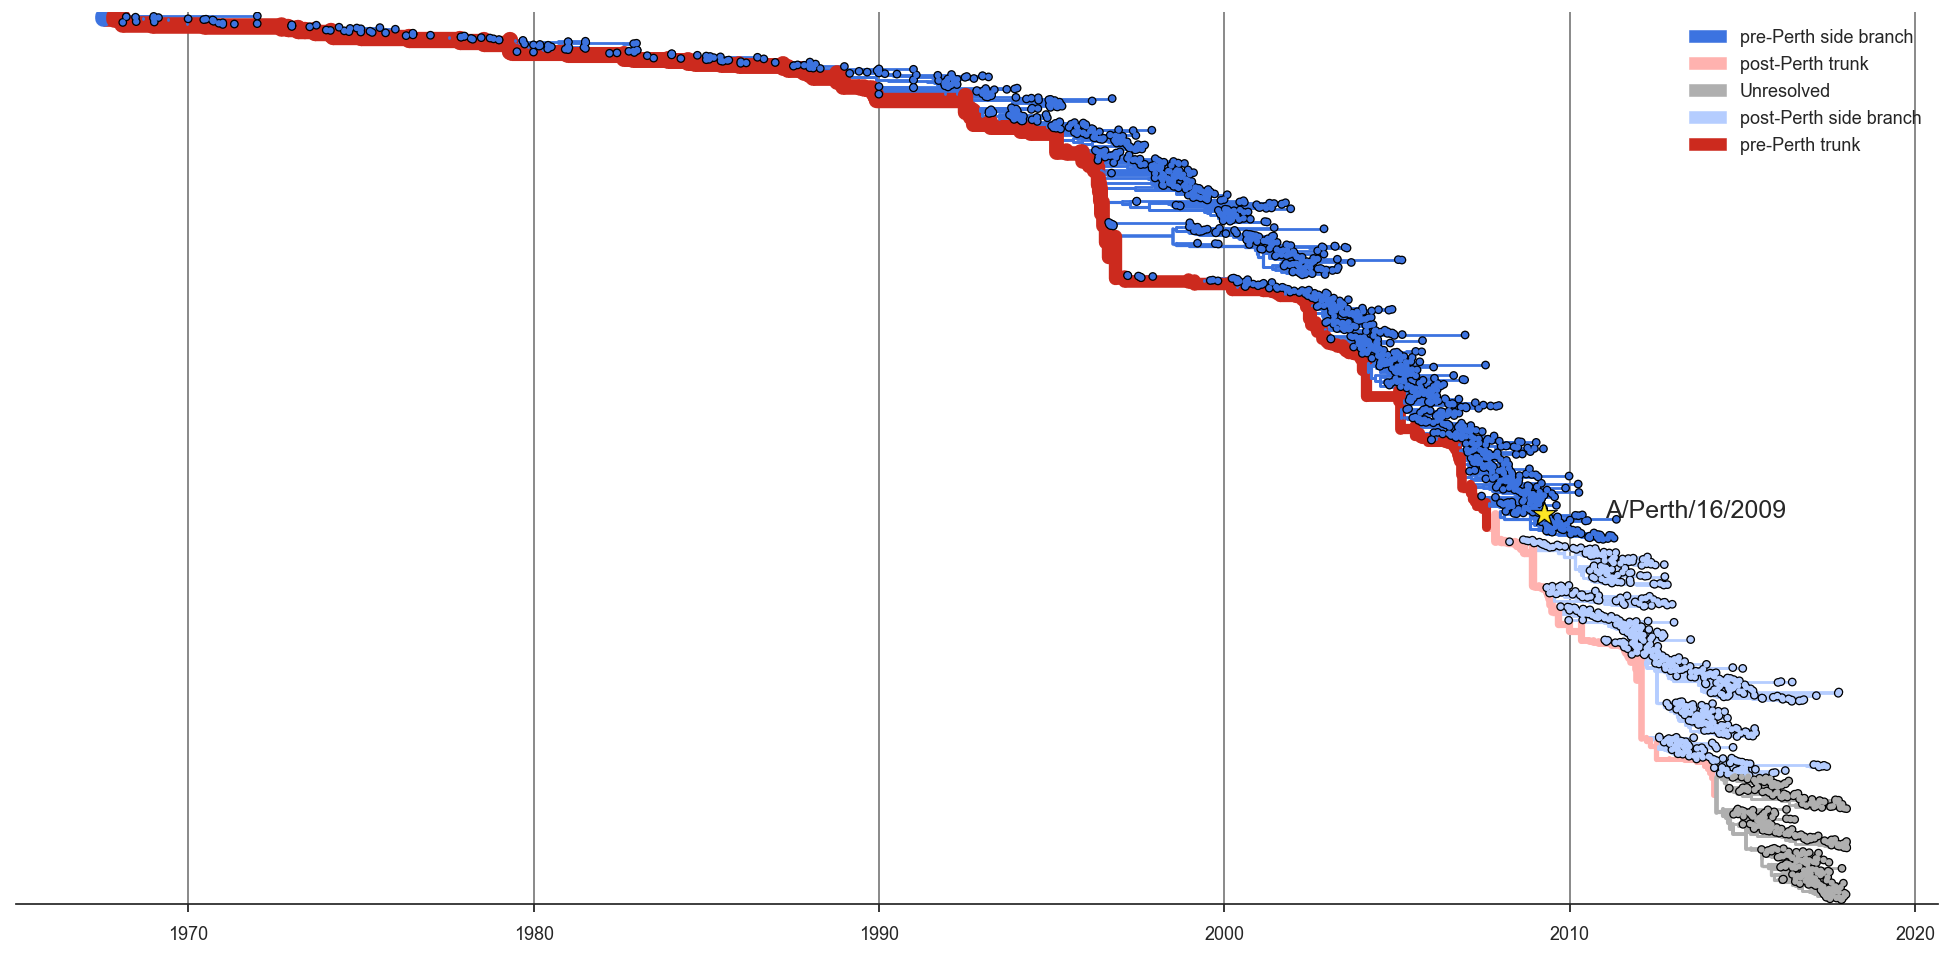

In [207]:
# Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 100

# Use simple plot style with figures sized for context of a talk.
sns.set_style("ticks")
sns.set_context("talk")

mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=22

yvalues = [node.yvalue for node in tree.find_clades()]
y_span = max(yvalues)
y_unit = y_span / float(len(yvalues))

trait_name = "trunk_status"
fig, ax = plt.subplots(figsize=(20,10), facecolor='w')

L=len([k for k in tree.find_clades() if k.is_terminal()])

# Setup arrays for tip and internal node coordinates.
tip_circles_x = []
tip_circles_y = []
tip_circles_color = []
node_circles_x = []
node_circles_y = []
node_circles_color = []
node_line_widths = []
node_line_segments = []
node_line_colors = []
branch_line_segments = []
branch_line_widths = []
branch_line_colors = []
branch_line_labels = []

for k in tree.find_clades(): ## iterate over objects in tree
    x=k.attr["num_date"] ## or from x position determined earlier
    y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else
    
    if k.parent is None:
        xp = None
    else:
        xp=k.parent.attr["num_date"] ## get x position of current object's parent

    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
        
    c='k'
    label = ''
    if trait_name in k.attr:
        c = cmap[k.attr[trait_name]]
        label = label_map.get(k.attr[trait_name])
    
    branchWidth=2
    if k.is_terminal(): ## if leaf...
        s=20 ## tip size can be fixed
        
        tip_circles_x.append(x)
        tip_circles_y.append(y)
        tip_circles_color.append(c)
    else: ## if node...
        k_leaves = [child
                    for child in k.find_clades()
                    if child.is_terminal()]
        branchWidth+=10.0*len(k_leaves)/float(L)
        
        if len(k.clades)==1:
            node_circles_x.append(x)
            node_circles_y.append(y)
            node_circles_color.append(c)

        #node_line_segments.append([(x, k.clades[-1].yvalue), (x, k.clades[0].yvalue)])
        #node_line_widths.append(branchWidth)
        #node_line_colors.append(c)
        ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')
    
    branch_line_segments.append([(xp, y), (x, y)])
    branch_line_widths.append(branchWidth)
    branch_line_colors.append(c)
    branch_line_labels.append(label)
    #ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9, label=label)

# This approach will work with the next matplotlib release which adds the "capstyle" parameters for collections.
#node_lc = LineCollection(node_line_segments, zorder=9)
#node_lc.set_color(node_branch_colors)
#node_lc.set_linewidth(node_branch_widths)
#node_lc.set_linestyle("-")
#node_lc.set_capstyle("round")
#ax.add_collection(node_lc)

branch_lc = LineCollection(branch_line_segments, zorder=9)
branch_lc.set_color(branch_line_colors)
branch_lc.set_linewidth(branch_line_widths)
branch_lc.set_label(branch_line_labels)
branch_lc.set_linestyle("-")
ax.add_collection(branch_lc)
    
# Add circles for tips and internal nodes.
ax.scatter(tip_circles_x, tip_circles_y, s=s, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
ax.scatter(tip_circles_x, tip_circles_y, s=s*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

ax.set_ylim(-10, y_span + 10)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(axis='x',ls='-',color='grey')
ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])

#
# Annotate DMS strain.
#

# Call out the DMS strain with a bordered star.
star_size = 200
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size, facecolor=["#fde725"], zorder=20)
ax.scatter([dms_strain.attr["num_date"]], [dms_strain.yvalue], marker="*", s=star_size * 2, facecolor=["#000000"], zorder=19)

# Annotate the DMS strain name.
ax.text(dms_strain.attr["num_date"] + 1.75, dms_strain.yvalue - 8, dms_strain.strain, fontsize=18)

# # Add text for named clades.
# for named_clade in named_clades:
#     # Place the clade label on the branch between the named clade
#     # and its parent halfway between the two.
#     x_node = named_clade.parent.attr["num_date"]
#     x_clade = named_clade.attr["num_date"]    
#     x = x_node + ((x_clade - x_node) / 3.0)
    
#     # Place the label just below the branch itself.
#     y_node = named_clade.parent.yvalue
#     y = y_node - (10 * y_unit)

#     ax.text(x, y, named_clade.attr["clade_name"], fontsize=20, color="black", zorder=100)

# Draw a dashed line from the strain's star to the name.
#ax.hlines(dms_strain.yvalue, dms_strain.attr["num_date"] + 0.05, dms_strain.attr["num_date"] + 1.6, linestyles=":", zorder=19)

# Add legend for colors.
patches = []
for key in label_map.keys():
    if key != "recent":
        patches.append(mpatches.Patch(color=cmap[key], label=label_map[key]))
    
ax.legend(handles=patches)

plt.tight_layout()
# plt.savefig('{0}/H3N2_phylogeny.pdf'.format(plotsdir), format='pdf')
plt.show()

## Collect trunk and side branch mutations

Now that we have defined what is the trunk and what are side branches, we will traverse through the tree and collect all trunk and side branch mutations.
Note that we collect mutations even if they occur more than once on the tree. 
In other words, if for example, a mutation has occurred twice along the trunk, that mutation is counted twice and not just once.

Note that we will also collect side branch mutations that have occurred on internal nodes or on terminal nodes.

In [63]:
def collect_mutations_by_nodes(nodes):
    """Returns a unique set of amino acid mutations associated
    with the given nodes.
    """
    mutations = []
    for node in nodes:
        if hasattr(node, "aa_muts"):
            for segment in node.aa_muts:
                for mutation in node.aa_muts[segment]:
                    mutations.append(mutation + ':' + segment)
    
    return mutations

In [64]:
# Save all mutations along the trunk.
trunk_mutations = collect_mutations_by_nodes(trunk_path)

# Save all mutations from any side branch node.
side_branch_mutations = collect_mutations_by_nodes(side_branch_nodes)

# Save all mutations from side branch internal nodes
internal_node_mutations = collect_mutations_by_nodes(internal_side_branch_nodes)

# Save all mutations from side branch terminal nodes
terminal_node_mutations = collect_mutations_by_nodes(terminal_side_branch_nodes)

In [65]:
# Define a function to clean up the list of mutations
def PruneMutList(mutlist, exchars = ['X', '*', 'SigPep']):
    """This function reads in a list of mutations, 
    removes mutations with undesired characters (e.g., 'X', '*', etc.), 
    and returns a pruned list of mutations.
    The argument mutlist specifies the input list of mutations,
    and the argument exchars specifies a list of characters so that if a mutation has any of these characters,
    it should be removed from the list of mutations."""
    newmutlist = [str(mut) for mut in mutlist if not any(c in mut for c in exchars)]
    return newmutlist

In [66]:
all_trunk_muts = PruneMutList(trunk_mutations)
all_side_muts = PruneMutList(side_branch_mutations)
all_internal_node_muts = PruneMutList(internal_node_mutations)
all_terminal_node_muts = PruneMutList(terminal_node_mutations)

print ('There are {0} total trunk mutations.'.format(len(all_trunk_muts)))
print ('There are {0} total side branch mutations.'.format(len(all_side_muts)))
print ('There are {0} total internal node mutations.'.format(len(all_internal_node_muts)))
print ('There are {0} total terminal node mutations.'.format(len(all_terminal_node_muts)))

There are 146 total trunk mutations.
There are 2354 total side branch mutations.
There are 529 total internal node mutations.
There are 1825 total terminal node mutations.


## Calculate mutational effects for each mutation

Now we will use the experimentally-determined amino-acid preferences to calculate the effect of mutations for all trunk and side branch mutations.

In [67]:
def CalculateAllFitnessEffects(mutlist, preferences):
    """
    This function reads in a list of mutations and for each mutation,
    calculate the mutational effect as PI_Y / PI_X at site #.
    and returns a list of mutational effects for each of the mutations in the input list.
    
    Args:
        mutlist: list of input mutations. Must be formated as X#Y:SUBUNIT, 
            where X is the original amino-acid at site #, 
            Y is the amino-acid that site # has mutated into, 
            and SUBUNIT is the subunit of the protein (HA1 or HA2)
        preferences: preferences .csv file
        
    Returns:
        A list of mutational effects for each mutation in the input mutlist.
    """
    
    prefsdf = pd.read_csv(preferences)
        
    sites = prefsdf['site'].tolist()
    effectslist = []
    
    for mut in mutlist:
        regex = r"(\w\d{1,3}[^X,*]:HA[12])"
        match = re.search(regex, mut)
        if match:
            m = mut.split(':')[0]
            subunit = mut.split(':')[1]
            site = m[1:-1]
            aa1 = m[0]
            aa2 = m[-1]
        else:
            print ('{0} not a valid mutation.'.format(mut))
            continue 

        if subunit == 'HA1':
            if site in sites:
                aa1pref = prefsdf[prefsdf['site'] == site][aa1]
                aa2pref = prefsdf[prefsdf['site'] == site][aa2]
                muteffect = aa2pref/aa1pref
            else:
                continue
        elif subunit == 'HA2':
            if '(HA2)' + site in sites:
                aa1pref = prefsdf[prefsdf['site'] == '(HA2)'+site][aa1]
                aa2pref = prefsdf[prefsdf['site'] == '(HA2)'+site][aa2]
                muteffect = aa2pref/aa1pref
            else:
                continue

        effectslist.append(float(muteffect))
        
    return effectslist

## Calculate the mutational effects at epitope and non-epitope sites

Although HA is under pressure both to maintain its structure and function and to escape pre-existing immunity, epitope sites in particular are under strong diversifying selection by adaptive immunity. 
We next examined if our measurements described different patterns of evolution at epitope and non-epitope sites.

We used the classification of [Wolf et al. (2006)](https://biologydirect.biomedcentral.com/articles/10.1186/1745-6150-1-34) to define epitope and non-epitope sites. 
Under this classification, there are are 129 epitope sites out of the 567 sites in H3 HA.
These sites are listed in [./data/wolf_epitope_sites.csv](./data/wolf_epitope_sites.csv).

In [68]:
# Read in Wolf epitope sites
epi_sitesdf = pd.read_csv('./data/wolf_epitope_sites.csv')
epi_sites = epi_sitesdf[epi_sitesdf['epi'] == 'epitope']['site'].tolist()

In [69]:
epi_trunk_muts = [m for m in all_trunk_muts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]
epi_side_muts = [m for m in all_side_muts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]
epi_int_muts = [m for m in all_internal_node_muts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]
epi_term_muts = [m for m in all_terminal_node_muts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]

In [70]:
non_epi_trunk_muts = [m for m in all_trunk_muts if m not in epi_trunk_muts]
non_epi_side_muts = [m for m in all_side_muts if m not in epi_side_muts]
non_epi_int_muts = [m for m in all_internal_node_muts if m not in epi_int_muts]
non_epi_term_muts = [m for m in all_terminal_node_muts if m not in epi_term_muts]

In [71]:
non_epi_trunk_muts

['D31N:HA1',
 'E150G:HA2',
 'R212K:HA2',
 'L3F:HA1',
 'L2I:HA2',
 'F3L:HA1',
 'D2N:HA1',
 'I18V:HA2',
 'T160K:HA1',
 'R124K:HA2',
 'V55L:HA2',
 'N2K:HA1',
 'K121R:HA2',
 'D46N:HA2',
 'R123K:HA2',
 'E57G:HA2',
 'G225D:HA1',
 'V201A:HA2',
 'V202I:HA1',
 'W222R:HA1',
 'L25I:HA1',
 'T32I:HA2',
 'D225N:HA1',
 'N46D:HA2',
 'R121K:HA2',
 'I32R:HA2',
 'V223I:HA1',
 'Q33R:HA1',
 'D160N:HA2',
 'N225D:HA1',
 'L3I:HA1',
 'K160T:HA1']

In [77]:
epi_trunk_muts_effects = CalculateAllFitnessEffects(epi_trunk_muts, rescaledavgprefs)
epi_side_muts_effects = CalculateAllFitnessEffects(epi_side_muts, rescaledavgprefs)
epi_int_effects = CalculateAllFitnessEffects(epi_int_muts, rescaledavgprefs)
epi_term_effects = CalculateAllFitnessEffects(epi_term_muts, rescaledavgprefs)

non_epi_trunk_effects = CalculateAllFitnessEffects(non_epi_trunk_muts, rescaledavgprefs)
non_epi_side_effects = CalculateAllFitnessEffects(non_epi_side_muts, rescaledavgprefs)
non_epi_int_effects = CalculateAllFitnessEffects(non_epi_int_muts, rescaledavgprefs)
non_epi_term_effects = CalculateAllFitnessEffects(non_epi_term_muts, rescaledavgprefs)

In [78]:
print ('The median of epitope trunk mutational effects = {0}'.format(np.median(epi_trunk_muts_effects)))
print ('The median of epitope side branch mutational effects = {0}'.format(np.median(epi_side_muts_effects)))
print ('The median of non-epitope trunk mutational effects = {0}'.format(np.median(non_epi_trunk_effects)))
print ('The median of non-epitope side branch mutational effects = {0}\n'.format(np.median(non_epi_side_effects)))

epi_med_diff = np.log2(np.median(epi_trunk_muts_effects)) - np.log2(np.median(epi_side_muts_effects))
epi_int_diff = np.log2(np.median(epi_trunk_muts_effects)) - np.log2(np.median(epi_int_effects))
epi_term_diff = np.log2(np.median(epi_trunk_muts_effects)) - np.log2(np.median(epi_term_effects))

non_epi_med_diff = np.log2(np.median(non_epi_trunk_effects)) - np.log2(np.median(non_epi_side_effects))
non_epi_int_diff = np.log2(np.median(non_epi_trunk_effects)) - np.log2(np.median(non_epi_int_effects))
non_epi_term_diff = np.log2(np.median(non_epi_trunk_effects)) - np.log2(np.median(non_epi_term_effects))

print ('The difference between the medians of \
trunk and internal node mutational effects at epitope sites = {0}'.format(epi_int_diff))
print ('The difference between the medians of \
trunk and terminal node mutational effects at epitope sites = {0}\n'.format(epi_term_diff))

print ('The difference between the medians of \
trunk and internal node mutational effects at non-epitope sites = {0}'.format(non_epi_int_diff))
print ('The difference between the medians of \
trunk and terminal node mutational effects at non-epitope sites = {0}'.format(non_epi_term_diff))

The median of epitope trunk mutational effects = 1.4803988676657989
The median of epitope side branch mutational effects = 0.40573467797041063
The median of non-epitope trunk mutational effects = 1.170716731334852
The median of non-epitope side branch mutational effects = 0.35739438232529586

The difference between the medians of trunk and internal node mutational effects at epitope sites = 1.4391598486586463
The difference between the medians of trunk and terminal node mutational effects at epitope sites = 2.0843395828458076

The difference between the medians of trunk and internal node mutational effects at non-epitope sites = 1.4852822094159173
The difference between the medians of trunk and terminal node mutational effects at non-epitope sites = 1.7539302490977045


In [89]:
nonepimuteffects = []
nonepimuteffects.append([e for e in np.log2(non_epi_side_effects)])
nonepimuteffects.append([e for e in np.log2(non_epi_trunk_effects)])

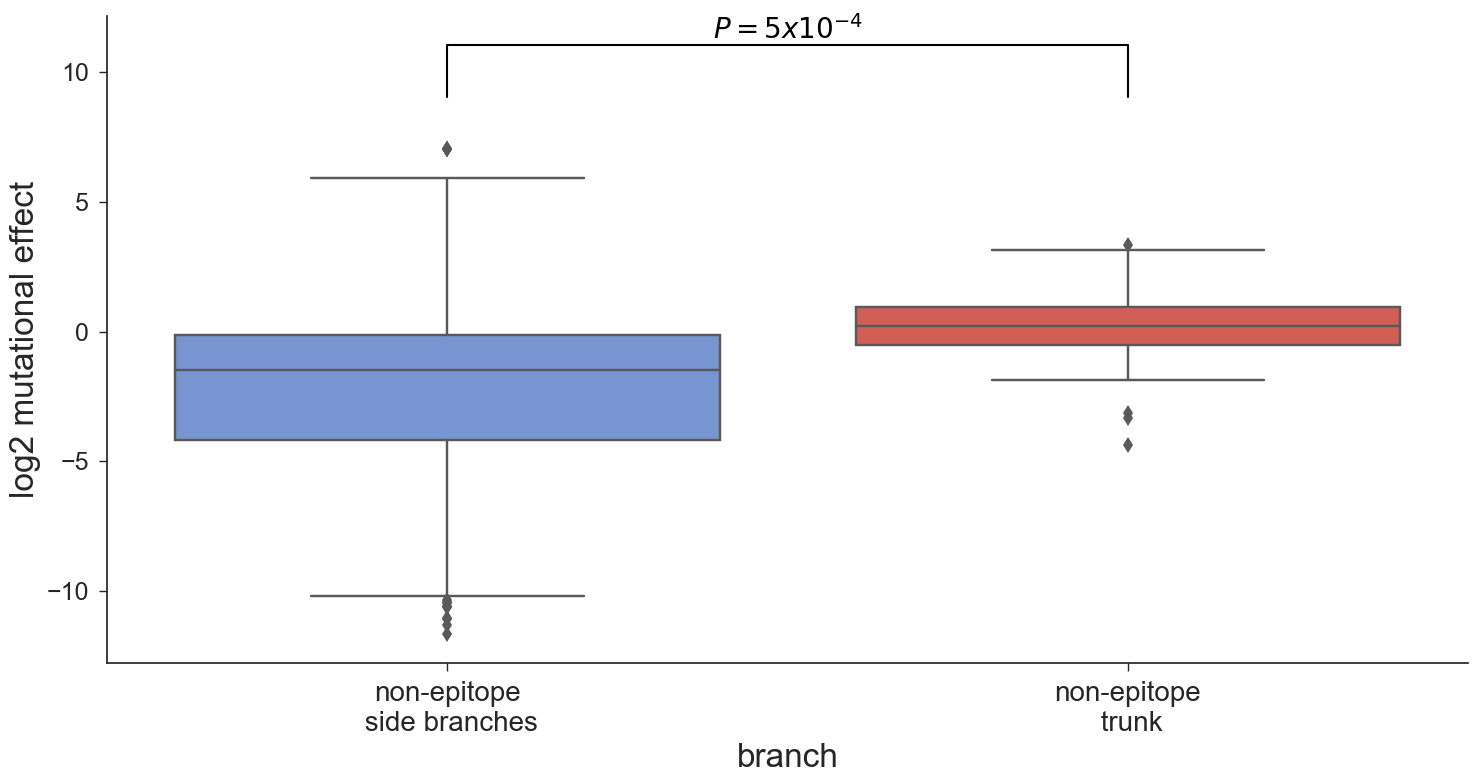

In [230]:
sns.set()
flatui = ['#6891e0', '#e54d42', '#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=nonepimuteffects, fliersize=8)
g.set_xticklabels(['non-epitope\n side branches', 'non-epitope\n trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

y1, h, col = max(epimuteffects[0] + epimuteffects[1]) + 2, 2, 'k'
plt.plot([0, 0, 1, 1], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
plt.text((0+1)*.5, y1+h, "$P = 5x10^{-4}$", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/nonepitope_sidebr_trunk.pdf'.format(plotsdir), format='pdf')
plt.show()

We see that trunk mutations are more favorable than side branch mutations at both epitope **and** non-epitope sites.
These results suggest that although epitope sites are predominantly under immune selection, these sites are also under functional constraint.

In [74]:
nodes_muteffects = []
nodes_muteffects.append([e for e in np.log2(non_epi_term_effects)])
nodes_muteffects.append([e for e in np.log2(non_epi_int_effects)])
nodes_muteffects.append([e for e in np.log2(non_epi_trunk_effects)])

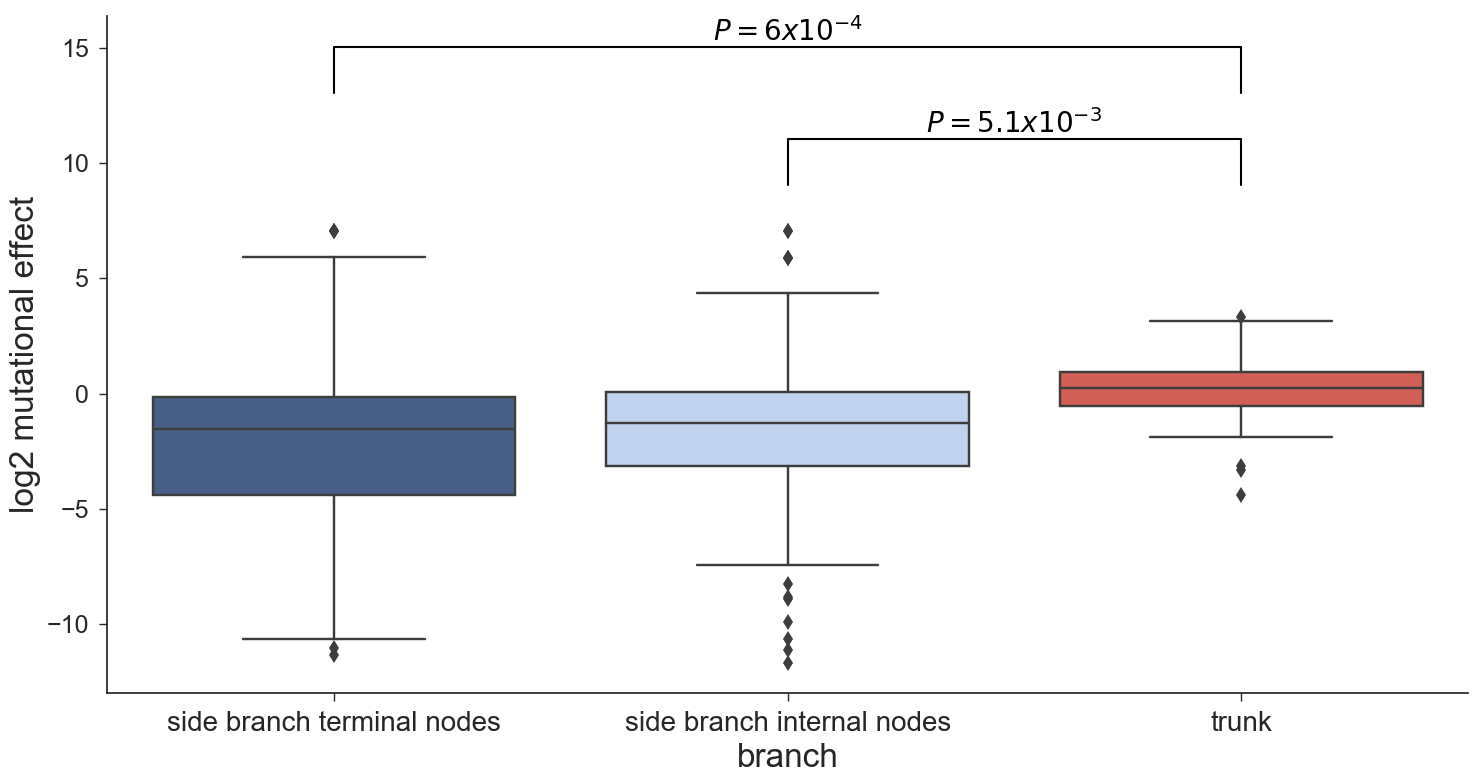

In [75]:
sns.set()
triplet = ['#3c5c90', '#b9d0f6', '#e54d42']
sns.color_palette(triplet)
sns.set_palette(triplet)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=nodes_muteffects, fliersize=8)
g.set_xticklabels(['side branch terminal nodes','side branch internal nodes','trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

y, h, col = max(nodes_muteffects[1] + nodes_muteffects[2]) + 2, 2, 'k'
plt.plot([1, 1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.plot([0, 0, 2, 2], [y+h+h, y+h+h+h, y+h+h+h, y+h+h], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "$P = 5.1x10^{-3}$", ha='center', va='bottom', color=col, fontsize = 20)
plt.text((0+2)*.5, y+h+h+h, "$P = 6x10^{-4}$", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/nonepitope_int_termnodes_trunk_1968-2012.pdf'.format(plotsdir), format='pdf')
plt.show()

In [80]:
epi_nodes_muteffects = []
epi_nodes_muteffects.append([e for e in np.log2(epi_term_effects)])
epi_nodes_muteffects.append([e for e in np.log2(epi_int_effects)])
epi_nodes_muteffects.append([e for e in np.log2(epi_trunk_muts_effects)])

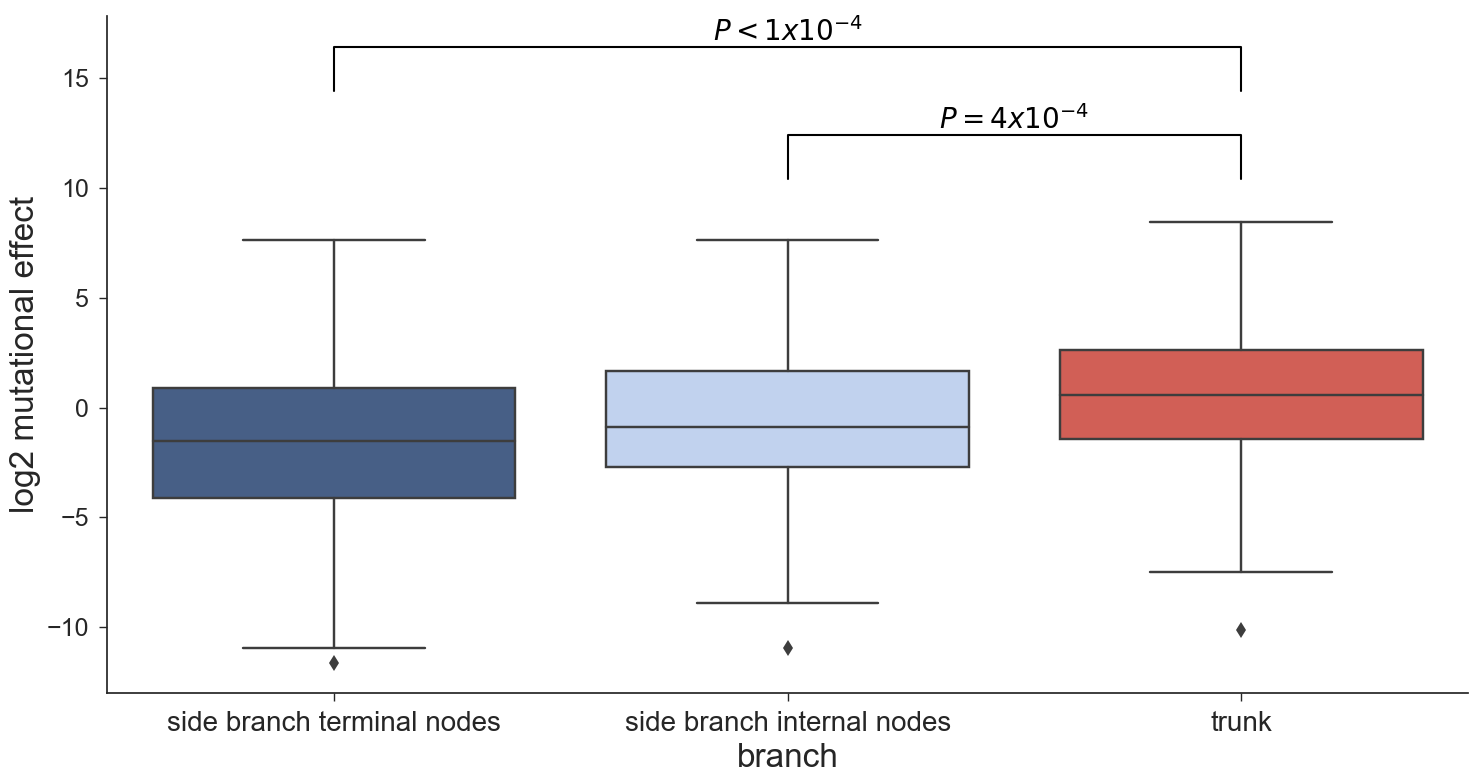

In [206]:
sns.set()
triplet = ['#3c5c90', '#b9d0f6', '#e54d42']
sns.color_palette(triplet)
sns.set_palette(triplet)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=epi_nodes_muteffects, fliersize=8)
g.set_xticklabels(['side branch terminal nodes','side branch internal nodes','trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

y, h, col = max(epi_nodes_muteffects[1] + epi_nodes_muteffects[2]) + 2, 2, 'k'
plt.plot([1, 1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.plot([0, 0, 2, 2], [y+h+h, y+h+h+h, y+h+h+h, y+h+h], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "$P = 4x10^{-4}$", ha='center', va='bottom', color=col, fontsize = 20)
plt.text((0+2)*.5, y+h+h+h, "$P < 1x10^{-4}$", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/epitope_int_termnodes_trunk.pdf'.format(plotsdir), format='pdf')
plt.show()

## Calculate mutational effects for shuffled preferences

The results above suggest that trunk mutational effects are, on average, higher than side branch mutational effects.
However, we want to know how significant this finding is. 
To determine significance, we will shuffle the preferences across sites, recalculate the median mutational effects for all trunk and side branch mutations using the shuffled preferences, and repeat this randomization 10,000 times.
We can then see how frequently the shuffled preferences give a difference in trunk vs side branch mutational effects that exceed the true difference in medians.

To do this randomization, we first write a function to parse through a list of mutations that can then be used as input into a function that shuffles the preferences and calculates the mutational effects using the shuffled preferences.

In [83]:
def ParseMutListToTuples(mutlist):
    """
    This function reads in a list of mutations and returns the same list of mutations,
    but with each mutation formatted as a tuple.
    Args:
        mutlist: input list of mutations
    Returns:
        a list of mutations with each mutation formatted as a tuple like so: (subunit, site, aa1, aa2)
    """
    parsedmuts = []
    for mut in mutlist:
        regex = r"(\w\d{1,3}[^X,*]:HA[12])"
        match = re.search(regex, mut)
        if match:
            m = mut.split(':')[0]
            subunit = mut.split(':')[1]
            site = m[1:-1]
            aa1 = m[0]
            aa2 = m[-1]
        else:
            print ('{0} not a valid mutation.'.format(mut))
            continue
        
        parsedmuts.append((subunit, site, aa1, aa2))
    return parsedmuts

In [84]:
epi_trunk_parsed = ParseMutListToTuples(epi_trunk_muts)
epi_int_parsed = ParseMutListToTuples(epi_int_muts)
epi_term_parsed = ParseMutListToTuples(epi_term_muts)

non_epi_trunk_parsed = ParseMutListToTuples(non_epi_trunk_muts)
non_epi_side_parsed = ParseMutListToTuples(non_epi_side_muts)
non_epi_int_parsed = ParseMutListToTuples(non_epi_int_muts)
non_epi_term_parsed = ParseMutListToTuples(non_epi_term_muts)

In [85]:
def ShufflePrefs(m1name, m1, m2name, m2, preferences, iterations=1000, sites=None, exclude_sites=False):
    """
    This function reads in two lists of mutations and a preferences file,
    shuffle the preferences across sites, and calculate the mutational effects
    of the two sets of mutations using the shuffled preferences.
    The median of the mutational effects for a given list of mutations will be
    added to a list in a dictionary keyed by the name of the mutation sets.
    It will then repeat this randomization the number of iterations specified 
    by the user.
    
    Args:
        `m1name` and `m2name`: are strings signifying the name that should be given 
            to the list of `m1` and `m2` mutations.
        `m1` and `m2`: lists containing mutations formatted as tuples 
            (created using the `ParseMutListToTuples` function defined above)
            such that each tuple contains the following (subunit, site, aa1, aa2).
        `preferences`: preferences file used as input.
        `iterations`: number of iterations to be completed (default=1000).
        `sites`: specify a list of sites to randomize among.
        `exclude_sites`: exclude the sites in `sites`? (default = False)
    Returns:
        A dictionary of shuffled median mutational effects keyed by m1name and m2name.
    """
    
    prefsdf = pd.read_csv(preferences)
    if sites:
        if exclude_sites is True:
            allsites = prefsdf['site'].tolist()
            siteslist = [s for s in allsites if s not in sites]
            prefsdf = prefsdf[prefsdf['site'].isin(siteslist)]
        else:
            siteslist = sites
            prefsdf = prefsdf[prefsdf['site'].isin(siteslist)]
    else:
        siteslist = prefsdf['site'].tolist()
    
    shuffledmuteffects = {m1name: [], m2name: []}
    
    muts = [(m1name, m1), (m2name, m2)]
    random.seed(10)
    
    for x in range(iterations):
        random.shuffle(siteslist)
        prefsdf['site'] = siteslist
        prefsdf.set_index('site', drop = True, inplace = True)
        prefsdict = prefsdf.to_dict(orient = 'index')
        for (name, mutations) in muts:
            muteffects = []
            for (subunit, site, aa1, aa2) in mutations:
                if subunit == 'HA1' and site in siteslist:
                    aa1pref = prefsdict[site][aa1]
                    aa2pref = prefsdict[site][aa2]
                    muteffect = np.log2(aa2pref/aa1pref)
                elif subunit == 'HA2' and ('(HA2)' + site) in siteslist:
                    aa1pref = prefsdict['(HA2)'+site][aa1]
                    aa2pref = prefsdict['(HA2)'+site][aa2]
                    muteffect = np.log2(aa2pref/aa1pref)
                muteffects.append(float(muteffect))
            shuffledmuteffects[name].append(float(np.median(muteffects)))
    
    return shuffledmuteffects

In [86]:
num_iter = 10000

In [71]:
non_epi_trunk_sidebr_shuffled = ShufflePrefs('trunk', non_epi_trunk_parsed, 
                                             'side_branch', non_epi_side_parsed, 
                                             rescaledavgprefs, iterations = num_iter, 
                                             sites=epi_sites, exclude_sites=True)

In [72]:
shuffleddf_nonepi = pd.DataFrame.from_dict(non_epi_trunk_sidebr_shuffled)
shuffleddf_nonepi['effectdiff'] = shuffleddf_nonepi.trunk - shuffleddf_nonepi.side_branch
print ('This is the number of trunk median minus side branch median differences at non-epitope sites \
that are > {0}:'.format(non_epi_med_diff))
print (sum(e > non_epi_med_diff for e in shuffleddf_nonepi.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= non_epi_med_diff for e in shuffleddf_nonepi.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch median differences at non-epitope sites that are greater than > 1.7118031782670802:
5
This is 0.05% of the randomizations.


In [102]:
non_epi_int_shuffled = ShufflePrefs('trunk', non_epi_trunk_parsed, 
                                    'sidebr_internal_nodes', non_epi_int_parsed, 
                                    rescaledavgprefs, iterations = num_iter, 
                                    sites = epi_sites, exclude_sites=True)

In [106]:
shuffleddf_int = pd.DataFrame.from_dict(non_epi_int_shuffled)
shuffleddf_int['effectdiff'] = shuffleddf_int.trunk - shuffleddf_int.sidebr_internal_nodes
print ('This is the number of trunk median minus side branch internal node median differences at non-epitope sites \
that are > {0}:'.format(non_epi_int_diff))
print (sum(e > non_epi_int_diff for e in shuffleddf_int.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= non_epi_int_diff for e in shuffleddf_int.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch internal node median differences at non-epitope sites that are > 1.4852822094159173:
51
This is 0.51% of the randomizations.


In [104]:
non_epi_term_shuffled = ShufflePrefs('trunk', non_epi_trunk_parsed, 
                                     'sidebr_terminal_nodes', non_epi_term_parsed, 
                                     rescaledavgprefs, iterations = num_iter, 
                                     sites = epi_sites, exclude_sites=True)

In [108]:
shuffleddf_term = pd.DataFrame.from_dict(non_epi_term_shuffled)
shuffleddf_term['effectdiff'] = shuffleddf_term.trunk - shuffleddf_term.sidebr_terminal_nodes
print ('This is the number of trunk median minus side branch terminal node median differences at non-epitope sites \
that are > {0}:'.format(non_epi_term_diff))
print (sum(e > non_epi_term_diff for e in shuffleddf_term.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= non_epi_term_diff for e in shuffleddf_term.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch terminal node median differences at non-epitope sites that are greater than > 1.7539302490977045:
6
This is 0.06% of the randomizations.


In [89]:
epi_int_shuffled = ShufflePrefs('trunk', epi_trunk_parsed, 
                                'sidebr_internal_nodes', epi_int_parsed, 
                                rescaledavgprefs, iterations = num_iter, 
                                sites = epi_sites)

In [91]:
shuffleddf_epi_int = pd.DataFrame.from_dict(epi_int_shuffled)
shuffleddf_epi_int['effectdiff'] = shuffleddf_epi_int.trunk - shuffleddf_epi_int.sidebr_internal_nodes
print ('This is the number of trunk median minus side branch internal node median differences at epitope sites \
that are greater than > {0}:'.format(epi_int_diff))
print (sum(e > epi_int_diff for e in shuffleddf_epi_int.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= epi_int_diff for e in shuffleddf_epi_int.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch internal node median differences at epitope sites that are greater than > 1.4391598486586463:
4
This is 0.04% of the randomizations.


In [92]:
epi_term_shuffled = ShufflePrefs('trunk', epi_trunk_parsed, 
                                 'sidebr_terminal_nodes', epi_term_parsed, 
                                 rescaledavgprefs, iterations = num_iter, 
                                 sites = epi_sites)

In [93]:
shuffleddf_epi_term = pd.DataFrame.from_dict(epi_term_shuffled)
shuffleddf_epi_term['effectdiff'] = shuffleddf_epi_term.trunk - shuffleddf_epi_term.sidebr_terminal_nodes
print ('This is the number of trunk median minus side branch terminal node median differences at epitope sites \
that are greater than > {0}:'.format(epi_term_diff))
print (sum(e > epi_term_diff for e in shuffleddf_epi_term.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= epi_term_diff for e in shuffleddf_epi_term.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch terminal node median differences at epitope sites that are greater than > 2.0843395828458076:
0
This is 0.0% of the randomizations.


## Sliding window analysis

Do the effects of mutations as quantified from the Perth/2009 H3 HA preferences degrade with increasing divergence from the HA we performed the deep mutational scanning experiments on?
To address this question, we will now analyze the mutational effects on portions of the phylogenetic tree using a sliding window analysis.

In [98]:
# Create a lookup table of nodes by name.
nodes_by_name = dict([(node.name, node) for node in tree.find_clades()])

In [99]:
def make_windows(length, window, slide, start=0):
    """
    For a given length, return an iterator for intervals of length `window` with
    a slide of `slide`.
    
    >>> list(make_windows(8, 4, 0))
    [(0, 4), (4, 8)]
    >>> list(make_windows(8, 5, 0))
    [(0, 5), (5, 8)]
    >>> list(make_windows(8, 8, 0))
    [(0, 8)]
    >>> list(make_windows(8, 4, 2))
    [(0, 4), (2, 6), (4, 8)]
    >>> list(make_windows(8, 5, 2))
    [(0, 5), (2, 7), (4, 8)]
    >>> list(make_windows(7, 8, 0))
    [(0, 7)]
    >>> list(make_windows(8, 4, 2, start=2010))
    [(2010, 2014), (2012, 2016), (2014, 2018)]
    """
    if slide == 0:
        window_starts = range(start, start + length, window)
    else:
        window_starts = range(start, start + length, slide)

    for window_start in window_starts:
        yield (window_start, min(window_start + window, start + length))

        # At most, only output one window at the end of the sequence.
        if start + length <= window_start + window:
            break

In [100]:
# Window size in years.
window_size = 12

# Sliding size in years.
window_slide = 1

# Interval length in years (end year - start year).
interval_length = 2015 - 1968

In [101]:
windows = list(make_windows(interval_length, window_size, window_slide, start=1968))

In [102]:
node_by_window = defaultdict(list)

In [103]:
for node in tree.find_clades():
    for window in windows:
        # Is this node in the current window?
        if node not in unresolved_nodes:
            if node.attr["num_date"] >= window[0] and node.attr["num_date"] < window[1]:
                node_by_window[window].append(node)

In [104]:
trunk_node_by_window = defaultdict(list)

for node in tree.find_clades():
    for window in windows:
        if node not in unresolved_nodes:
            # Is this node in the current window?
            if node.attr["num_date"] >= window[0] and node.attr["num_date"] < window[1]:
                if node.is_trunk:
                    trunk_node_by_window[window].append(node)

In [105]:
sidebr_node_by_window = defaultdict(list)

for node in tree.find_clades():
    for window in windows:
        if node not in unresolved_nodes:
            # Is this node in the current window?
            if node.attr["num_date"] >= window[0] and node.attr["num_date"] < window[1]:
                if not node.is_trunk:
                    sidebr_node_by_window[window].append(node)

In [106]:
epi_trunk_muts_by_window = {}
nonepi_trunk_muts_by_window = {}
for window in sorted(trunk_node_by_window.keys()):
    trunkmuts = collect_mutations_by_nodes(trunk_node_by_window[window])
    prunedtrunkmuts = PruneMutList(trunkmuts)
    epi_muts = [m for m in prunedtrunkmuts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]
    nonepi_muts = [m for m in prunedtrunkmuts if m not in epi_muts]
    epi_trunk_muts_by_window[window] = epi_muts
    nonepi_trunk_muts_by_window[window] = nonepi_muts
    
epi_side_muts_by_window = {}
nonepi_side_muts_by_window = {}
for window in sorted(sidebr_node_by_window.keys()):
    sidemuts = collect_mutations_by_nodes(sidebr_node_by_window[window])
    prunedsidemuts = PruneMutList(sidemuts)
    epi_muts = [m for m in prunedsidemuts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]
    nonepi_muts = [m for m in prunedsidemuts if m not in epi_muts]
    epi_side_muts_by_window[window] = epi_muts
    nonepi_side_muts_by_window[window] = nonepi_muts

In [107]:
for window in sorted(trunk_node_by_window.keys()):
    # Report number nodes per window.
    print ('{0} has {1} trunk and {2} side branch mutations'.format(window, 
                                                                    len(nonepi_trunk_muts_by_window[window]), 
                                                                    len(nonepi_side_muts_by_window[window])))

(1968, 1980) has 9 trunk and 47 side branch mutations
(1969, 1981) has 9 trunk and 51 side branch mutations
(1970, 1982) has 9 trunk and 51 side branch mutations
(1971, 1983) has 9 trunk and 52 side branch mutations
(1972, 1984) has 9 trunk and 47 side branch mutations
(1973, 1985) has 7 trunk and 44 side branch mutations
(1974, 1986) has 6 trunk and 44 side branch mutations
(1975, 1987) has 6 trunk and 37 side branch mutations
(1976, 1988) has 6 trunk and 34 side branch mutations
(1977, 1989) has 5 trunk and 39 side branch mutations
(1978, 1990) has 4 trunk and 39 side branch mutations
(1979, 1991) has 4 trunk and 35 side branch mutations
(1980, 1992) has 4 trunk and 35 side branch mutations
(1981, 1993) has 3 trunk and 35 side branch mutations
(1982, 1994) has 3 trunk and 45 side branch mutations
(1983, 1995) has 1 trunk and 63 side branch mutations
(1984, 1996) has 2 trunk and 72 side branch mutations
(1985, 1997) has 3 trunk and 93 side branch mutations
(1986, 1998) has 4 trunk and

In [110]:
nonepi_trunk_muteffects_window = {}
for window in sorted(nonepi_trunk_muts_by_window.keys()):
    trunkmuteffects = CalculateAllFitnessEffects(nonepi_trunk_muts_by_window[window], rescaledavgprefs)
    nonepi_trunk_muteffects_window[window] = trunkmuteffects

nonepi_side_muteffects_window = {}
for window in sorted(nonepi_side_muts_by_window.keys()):
    sidemuteffects = CalculateAllFitnessEffects(nonepi_side_muts_by_window[window], rescaledavgprefs)
    nonepi_side_muteffects_window[window] = sidemuteffects

In [108]:
epi_trunk_muteffects_window = {}
for window in sorted(epi_trunk_muts_by_window.keys()):
    trunkmuteffects = CalculateAllFitnessEffects(epi_trunk_muts_by_window[window], rescaledavgprefs)
    epi_trunk_muteffects_window[window] = trunkmuteffects
    
epi_side_muteffects_window = {}
for window in sorted(epi_side_muts_by_window.keys()):
    sidemuteffects = CalculateAllFitnessEffects(epi_side_muts_by_window[window], rescaledavgprefs)
    epi_side_muteffects_window[window] = sidemuteffects

In [111]:
nonepi_muteffectlist_trunk = [[window, np.log2(muteffect), 'trunk'] for window in sorted(nonepi_trunk_muteffects_window.keys()) for muteffect in nonepi_trunk_muteffects_window[window]]
nonepi_muteffectlist_side = [[window, np.log2(muteffect), 'side branch'] for window in sorted(nonepi_side_muteffects_window.keys()) for muteffect in nonepi_side_muteffects_window[window]]

epi_muteffectlist_trunk = [[window, np.log2(muteffect), 'trunk'] for window in sorted(epi_trunk_muteffects_window.keys()) for muteffect in epi_trunk_muteffects_window[window]]
epi_muteffectlist_side = [[window, np.log2(muteffect), 'side branch'] for window in sorted(epi_side_muteffects_window.keys()) for muteffect in epi_side_muteffects_window[window]]

In [112]:
nonepi_windowdf = pd.DataFrame(nonepi_muteffectlist_trunk, columns = ['window', 'muteffect', 'branch'])
nonepi_sidedf = pd.DataFrame(nonepi_muteffectlist_side, columns = ['window', 'muteffect', 'branch'])

nonepi_windowdf = nonepi_windowdf.append(nonepi_sidedf, ignore_index=True)
nonepi_windowdf = nonepi_windowdf.reset_index(drop=True)

In [113]:
epi_windowdf = pd.DataFrame(epi_muteffectlist_trunk, columns = ['window', 'muteffect', 'branch'])
epi_sidedf = pd.DataFrame(epi_muteffectlist_side, columns = ['window', 'muteffect', 'branch'])

epi_windowdf = epi_windowdf.append(epi_sidedf, ignore_index=True)
epi_windowdf = epi_windowdf.reset_index(drop=True)

In [133]:
# Calculate the interquartile ranges of mutational effects for each window
trunk_iqrs = {}
trunk_75iqr = []
trunk_25iqr = []
for window in sorted(nonepi_trunk_muteffects_window.keys()):
    q75, q25 = np.percentile(nonepi_trunk_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    trunk_iqrs[window] = [q75, q25]
    trunk_75iqr.append(q75)
    trunk_25iqr.append(q25)
    
side_iqrs = {}
side_75iqr = []
side_25iqr = []
for window in sorted(nonepi_side_muteffects_window.keys()):
    q75, q25 = np.percentile(nonepi_side_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    side_iqrs[window] = [q75, q25]
    side_75iqr.append(q75)
    side_25iqr.append(q25)

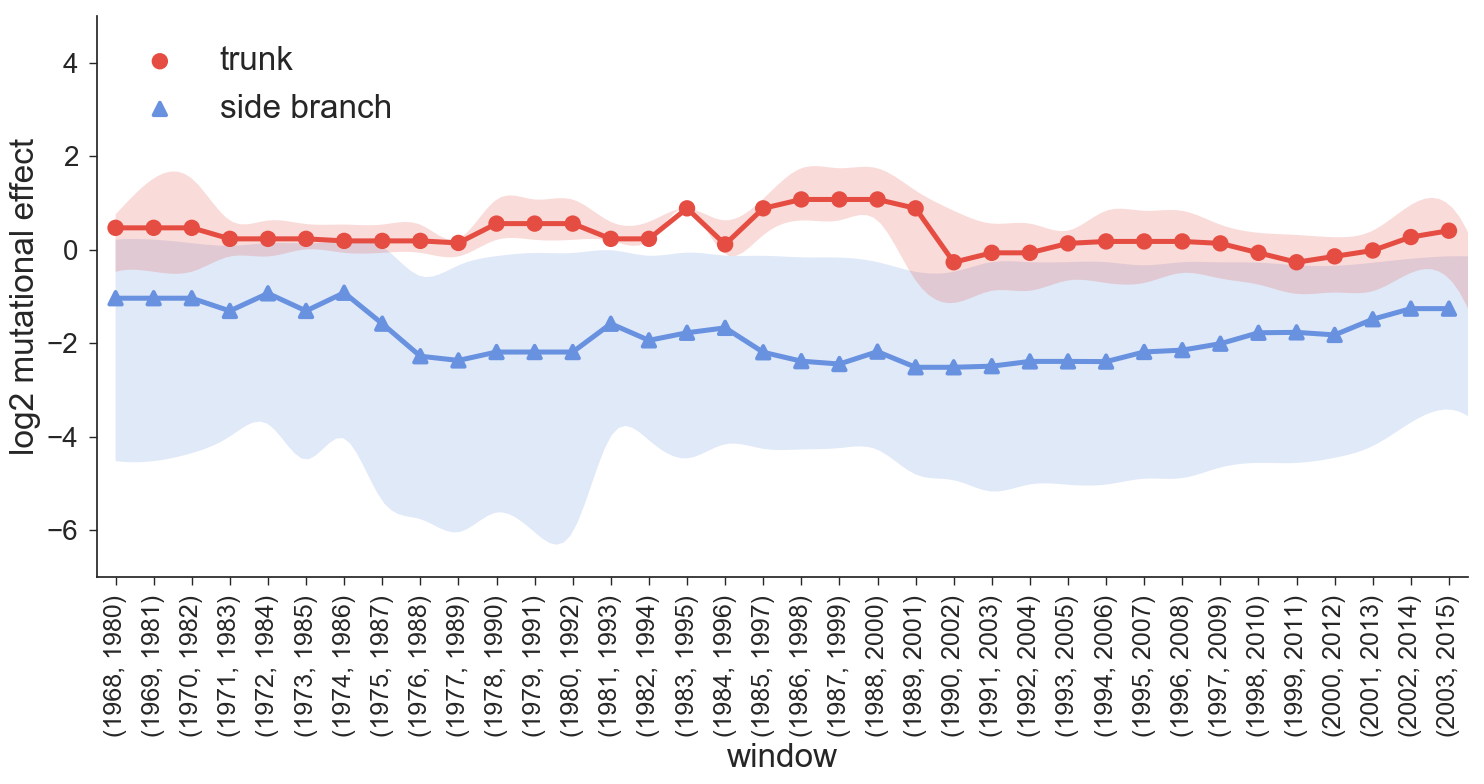

In [232]:
sns.set()
flatui = ['#e54d42', '#6891e0']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))

x2 = np.linspace(0, len(windows), 200)
trunk75_spl = splrep(range(len(windows)), trunk_75iqr)
trunk25_spl = splrep(range(len(windows)), trunk_25iqr)
trunk75_y2 = splev(x2, trunk75_spl)
trunk25_y2 = splev(x2, trunk25_spl)
side75_spl = splrep(range(len(windows)), side_75iqr)
side25_spl = splrep(range(len(windows)), side_25iqr)
side75_y2 = splev(x2, side75_spl)
side25_y2 = splev(x2, side25_spl)

ax.fill_between(x2, side75_y2, side25_y2, facecolor='#6891e0', edgecolor=None, alpha=0.2, linewidth=0)
ax.fill_between(x2, trunk75_y2, trunk25_y2, facecolor='#e54d42', edgecolor=None, alpha=0.2, linewidth=0)

g = sns.pointplot(x = 'window', y = 'muteffect', hue = 'branch', 
                  data=nonepi_windowdf, 
                  estimator=np.median, 
                  ci=None, 
                  markers=['o', '^'], 
                  scale=1.15)
ax.set_xlabel('window', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=18, rotation='vertical')
plt.yticks(fontsize=20)
plt.ylim(-7,5)

# plt.axhline(0, linewidth=2, color='#5e5e5e', linestyle='--')

sns.despine()
plt.legend(loc = 'upper left', prop= {'size': 24})
plt.tight_layout()
# plt.savefig('{0}/sidebrvstrunk_slidingwindow_nonepi_12y.pdf'.format(plotsdir), format='pdf')
plt.show()

In [114]:
# Calculate the interquartile ranges of mutational effects for each window
trunk_iqrs = {}
trunk_75iqr = []
trunk_25iqr = []
for window in sorted(epi_trunk_muteffects_window.keys()):
    q75, q25 = np.percentile(epi_trunk_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    trunk_iqrs[window] = [q75, q25]
    trunk_75iqr.append(q75)
    trunk_25iqr.append(q25)
    
side_iqrs = {}
side_75iqr = []
side_25iqr = []
for window in sorted(epi_side_muteffects_window.keys()):
    q75, q25 = np.percentile(epi_side_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    side_iqrs[window] = [q75, q25]
    side_75iqr.append(q75)
    side_25iqr.append(q25)

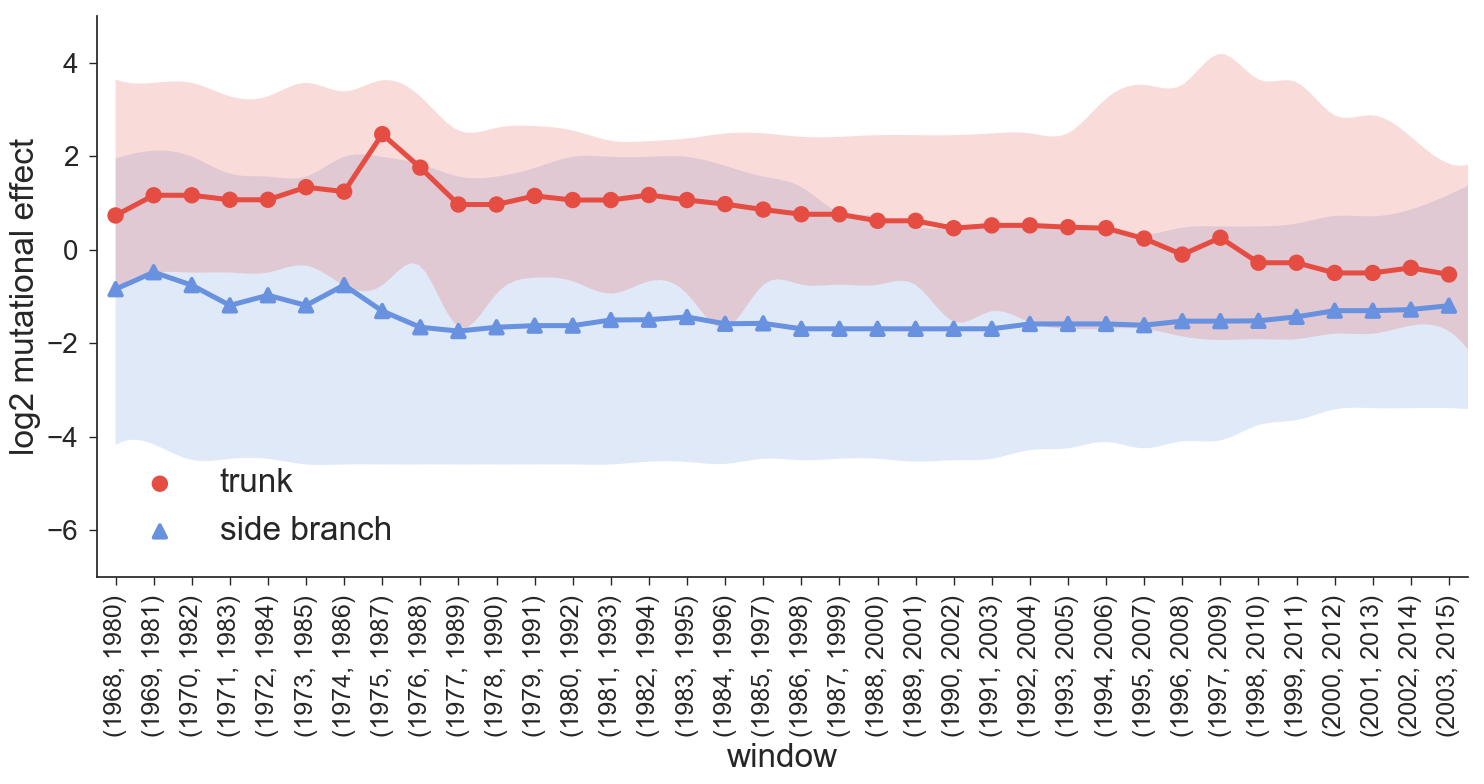

In [205]:
sns.set()
flatui = ['#e54d42', '#6891e0']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))

x2 = np.linspace(0, len(windows), 200)
trunk75_spl = splrep(range(len(windows)), trunk_75iqr)
trunk25_spl = splrep(range(len(windows)), trunk_25iqr)
trunk75_y2 = splev(x2, trunk75_spl)
trunk25_y2 = splev(x2, trunk25_spl)
side75_spl = splrep(range(len(windows)), side_75iqr)
side25_spl = splrep(range(len(windows)), side_25iqr)
side75_y2 = splev(x2, side75_spl)
side25_y2 = splev(x2, side25_spl)

ax.fill_between(x2, side75_y2, side25_y2, facecolor='#6891e0', edgecolor=None, alpha=0.2, linewidth=0)
ax.fill_between(x2, trunk75_y2, trunk25_y2, facecolor='#e54d42', edgecolor=None, alpha=0.2, linewidth=0)

g = sns.pointplot(x = 'window', y = 'muteffect', hue = 'branch', 
                  data=epi_windowdf, 
                  estimator=np.median, 
                  ci=None, 
                  markers=['o', '^'], 
                  scale=1.15)
ax.set_xlabel('window', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=18, rotation='vertical')
plt.yticks(fontsize=20)
plt.ylim(-7,5)

# plt.axhline(0, linewidth=2, color='#5e5e5e', linestyle='--')

sns.despine()
plt.legend(loc = 'lower left', prop= {'size': 24})
plt.tight_layout()
# plt.savefig('{0}/sidebrvstrunk_slidingwindow_epi_12y.pdf'.format(plotsdir), format='pdf')
plt.show()

The plot above shows that the trunk mutations consistently tend to be more favorable than side branch mutations across time.
Therefore, our experimental measurements reveal the selective advantage of the trunk over the side branches over ~50 y of evolution.

## Calculate mutational effects using WSN H1 preferences

We will now see if the amino-acid preferences measured in a diverged HA variant (the **WSN/1933 H1 HA** from [Doud and Bloom 2016](http://www.mdpi.com/1999-4915/8/6/155)) can help distinguish between trunk and side branch lineages.
The Perth/2009 H3 HA and the WSN/1933 H1 HA are 42% identical at the amino-acid level.

In [135]:
WSNprefs = './data/WSN_avgprefs_rescaled_H3numbering.csv'

In [136]:
WSNtrunk_muts_effects = CalculateAllFitnessEffects(non_epi_trunk_muts, WSNprefs)
WSNside_muts_effects = CalculateAllFitnessEffects(non_epi_side_muts, WSNprefs)

In [137]:
print ('The median of trunk mutational effects = {0}'.format(np.median(WSNtrunk_muts_effects)))
print ('The median of side branch mutational effects = {0}'.format(np.median(WSNside_muts_effects)))

WSN_trunkvssidebr_med_diff = np.log2(np.median(WSNtrunk_muts_effects)) - np.log2(np.median(WSNside_muts_effects))
print ('\nThe difference between the medians of \
trunk and side branch mutational effects = {0}'.format(WSN_trunkvssidebr_med_diff))

The median of trunk mutational effects = 0.7065452039474318
The median of side branch mutational effects = 0.5392323359447546

The difference between the medians of trunk and side branch mutational effects = 0.38987485280687606


In [138]:
WSNmuteffects = []
WSNmuteffects.append([e for e in np.log2(WSNside_muts_effects)])
WSNmuteffects.append([e for e in np.log2(WSNtrunk_muts_effects)])

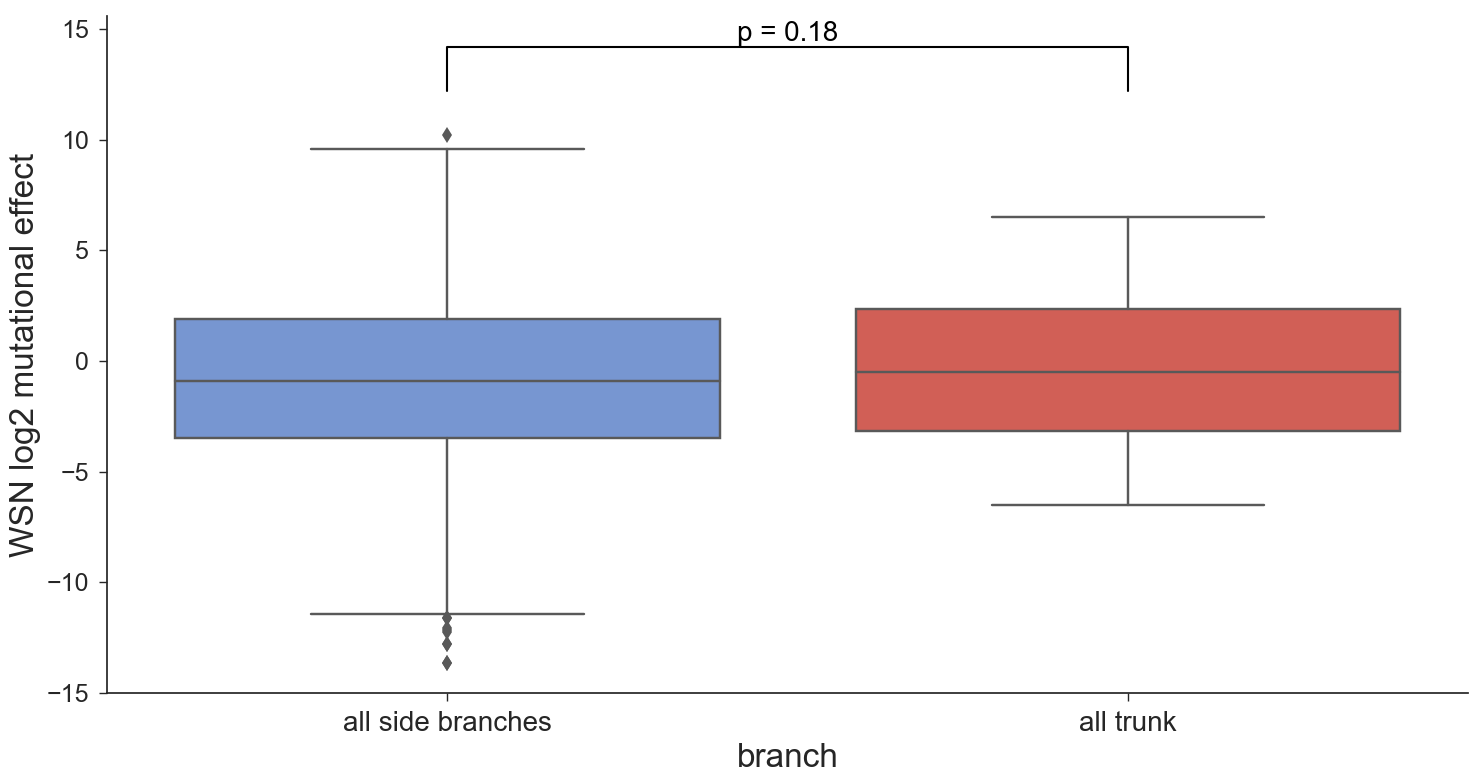

In [233]:
sns.set()
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=WSNmuteffects, fliersize=8)
g.set_xticklabels(['all side branches','all trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('WSN log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

x1, x2 = 0, 1
y, h, col = max(WSNmuteffects[0] + WSNmuteffects[1]) + 2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "p = 0.18", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/nonepi_sidebr_trunk_WSNlogmuteffect.pdf'.format(plotsdir), format='pdf')
plt.show()

In [141]:
WSNtrunk_sidebr_shuffled = ShufflePrefs('trunk', non_epi_trunk_parsed, 
                                        'side_branch', non_epi_side_parsed, 
                                        WSNprefs, iterations = num_iter, 
                                        sites=epi_sites, exclude_sites=True)

In [142]:
WSNshuffleddf = pd.DataFrame.from_dict(WSNtrunk_sidebr_shuffled)
WSNshuffleddf['effectdiff'] = WSNshuffleddf.trunk - WSNshuffleddf.side_branch
print ('This is the number of trunk median minus side branch median differences \
that are greater than > {0}:'.format(WSN_trunkvssidebr_med_diff))
print (sum(e > WSN_trunkvssidebr_med_diff for e in WSNshuffleddf.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= WSN_trunkvssidebr_med_diff for e in WSNshuffleddf.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch median differences that are greater than > 0.38987485280687606:
1768
This is 17.68% of the randomizations.


### Sliding window analysis using WSN/1933 H1 HA preferences

In [144]:
WSN_trunk_muteffects_window = {}
for window in sorted(nonepi_trunk_muts_by_window.keys()):
    WSNtrunkmuteffects = CalculateAllFitnessEffects(nonepi_trunk_muts_by_window[window], WSNprefs)
    WSN_trunk_muteffects_window[window] = WSNtrunkmuteffects

WSN_side_muteffects_window = {}
for window in sorted(nonepi_side_muts_by_window.keys()):
    WSNsidemuteffects = CalculateAllFitnessEffects(nonepi_side_muts_by_window[window], WSNprefs)
    WSN_side_muteffects_window[window] = WSNsidemuteffects

In [145]:
WSN_muteffectlist_trunk = [[window, np.log2(muteffect), 'trunk'] for window in sorted(WSN_trunk_muteffects_window.keys()) for muteffect in WSN_trunk_muteffects_window[window]]
WSN_muteffectlist_side = [[window, np.log2(muteffect), 'side branch'] for window in sorted(WSN_side_muteffects_window.keys()) for muteffect in WSN_side_muteffects_window[window]]

In [146]:
WSN_windowdf = pd.DataFrame(WSN_muteffectlist_trunk, columns = ['window', 'muteffect', 'branch'])
WSN_sidedf = pd.DataFrame(WSN_muteffectlist_side, columns = ['window', 'muteffect', 'branch'])

WSN_windowdf = WSN_windowdf.append(WSN_sidedf, ignore_index=True)
WSN_windowdf = WSN_windowdf.reset_index(drop=True)

In [147]:
WSN_trunk_iqrs = {}
WSN_trunk_75iqr = []
WSN_trunk_25iqr = []
for window in sorted(WSN_trunk_muteffects_window.keys()):
    q75, q25 = np.percentile(WSN_trunk_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    WSN_trunk_iqrs[window] = [q75, q25]
    WSN_trunk_75iqr.append(q75)
    WSN_trunk_25iqr.append(q25)
    
WSN_side_iqrs = {}
WSN_side_75iqr = []
WSN_side_25iqr = []
for window in sorted(WSN_side_muteffects_window.keys()):
    q75, q25 = np.percentile(WSN_side_muteffects_window[window], [75, 25])
    q75, q25 = np.log2(q75), np.log2(q25)
    WSN_side_iqrs[window] = [q75, q25]
    WSN_side_75iqr.append(q75)
    WSN_side_25iqr.append(q25)

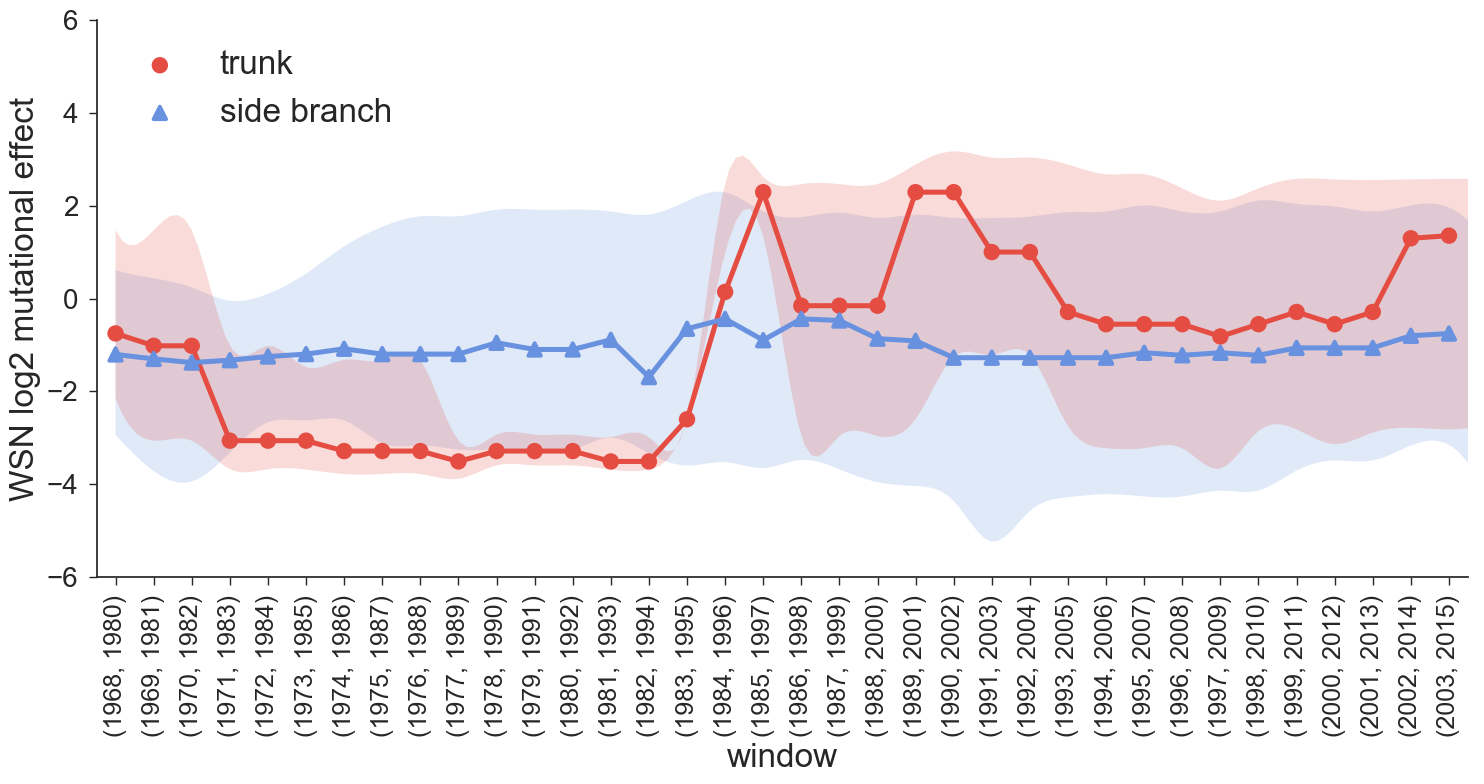

In [234]:
sns.set()
flatui = ['#e54d42', '#6891e0']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))

x2 = np.linspace(0, len(windows), 200)
WSN_trunk75_spl = splrep(range(len(windows)), WSN_trunk_75iqr)
WSN_trunk25_spl = splrep(range(len(windows)), WSN_trunk_25iqr)
WSN_trunk75_y2 = splev(x2, WSN_trunk75_spl)
WSN_trunk25_y2 = splev(x2, WSN_trunk25_spl)
WSN_side75_spl = splrep(range(len(windows)), WSN_side_75iqr)
WSN_side25_spl = splrep(range(len(windows)), WSN_side_25iqr)
WSN_side75_y2 = splev(x2, WSN_side75_spl)
WSN_side25_y2 = splev(x2, WSN_side25_spl)

ax.fill_between(x2, WSN_side75_y2, WSN_side25_y2, facecolor='#6891e0', edgecolor=None, alpha=0.2, linewidth=0)
ax.fill_between(x2, WSN_trunk75_y2, WSN_trunk25_y2, facecolor='#e54d42', edgecolor=None, alpha=0.2, linewidth=0)

g = sns.pointplot(x = 'window', y = 'muteffect', hue = 'branch', 
                  data=WSN_windowdf, 
                  estimator=np.median, 
                  ci=None, 
                  markers=['o', '^'], 
                  scale=1.15)
ax.set_xlabel('window', fontsize = 24)
ax.set_ylabel('WSN log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=18, rotation='vertical')
plt.yticks(fontsize=20)
plt.ylim(-6,6)

# plt.axhline(0, linewidth=2, color='#5e5e5e', linestyle='--')

sns.despine()
plt.legend(loc = 'upper left', prop= {'size': 24})
plt.tight_layout()
# plt.savefig('{0}/WSN_nonepi_sidebrvstrunk_slidingwindow_12y.pdf'.format(plotsdir), format='pdf')
plt.show()

Both the boxplot and the sliding window plot above show that the WSN/1933 H1 HA preferences do not reveal significantly more favorable mutations for the trunk lineage than for side branches on an H3N2 phylogenetic tree.
Therefore, these measurements in a diverged HA variant have sufficiently degraded that we are no longer able to distinguish differences in successful and unsuccessful lineages of seasonal influenza virus.

## Calculate sequence preference

Rather than looking at mutational effects, a more systematic way to evaluate differences in the trunk vs in side branches is to calculate **sequence preference**. 
This allows us to compare individual nodes on the tree and to evaluate how our experimental measurements may have shifted in diverse genetic backgrounds.

We calculated the average per-site sequence preference as 
$$ 
F (\textbf{s}) = \frac{1}{L} \displaystyle\sum_{r = 1}^{L} \ln \pi_{r, s_r} 
$$
where $\pi_{r, s_r}$ is the preference for the amino acid $s_r$ at site $r$ in HA sequence $\textbf{s}$, and $L$ is the length of the sequence.

We will calculate the sequence preference across all sites, epitope sites, or non-epitope sites.

In [117]:
def calc_tolerance(aa_sequence, preferences, positions=None):
    """Calculates log odds of a node's AA sequence relative to a set of
    site-specific AA preferences.
    
    The calculation can be limited to a given list of `positions` in the
    given sequence.
    """
    # Use all positions in the given sequence by default.
    if positions is None:
        positions = list(range(len(aa_sequence)))
    
    # Create a list of keys into the preference series where the first
    # value is the zero-based protein position and the second value is
    # the amino acid at that position in the given sequence.
    aa_array = [(i, aa_sequence[i]) for i in positions]
    
    # Look up preferences for the amino acids at each site in the given
    # protein using the given `preferences` series indexed by site and 
    # amino acid.
    node_preferences = preferences[aa_array]

    # Replace missing values with a very small probability. This
    # primarily accounts for stop codons ("X") that do not have an
    # associated DMS preference.
    node_preferences = node_preferences.fillna(1e-10)

    # Calculate sum of the log of the preferences the node's amino acid
    # sequence.
    tolerance = np.log(node_preferences).sum()

    return tolerance

In [118]:
prefsdf = pd.read_csv(rescaledavgprefs)
prefsdf.index.name = "HA_position"
prefsdf = prefsdf.reset_index()

In [119]:
stacked_preferences = prefsdf.stack()

In [174]:
# Calculate sequence preference across all sites in HA.
for node in tree.find_clades():
    node.attr["tol"] = calc_tolerance(node.aa_sequence, stacked_preferences)

In [175]:
# Define epitope bitmasks where 1 includes a given position in the mask and 0 excludes it.
epitope_mask = {}

# Koel mask
epitope_mask["koel"] = "00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000110110000000000000000000000000000010001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"

# Wolf mask
epitope_mask["wolf"] = "00000000000000000000000000000000000000000000000000000000000111110110110010100110001000000010010111100111001101010000011000001000000010001101010111111010110101111100010100111110001010110111111110100100011111011101110010100011100111111110000001111100000001010101011100000000000111001000000010110111000000000000010010110001101111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000"

In [176]:
epitope_sites = {}
nonepitope_sites = {}
for mask in epitope_mask.keys():
    int_mask = np.fromstring(epitope_mask[mask], "S1").astype(np.int0)
    epitope_sites[mask] = [i for i in range(len(int_mask))
                           if int_mask[i] == 1]
    nonepitope_sites[mask] = [i for i in range(len(int_mask))
                              if int_mask[i] == 0]

In [177]:
# Calculate sequence preference across epitope and non-epitope mask sites in HA.
for node in tree.find_clades():
    for mask in epitope_sites.keys():
        node.attr["tol_epitope_%s" % mask] = calc_tolerance(
            node.aa_sequence,
            stacked_preferences,
            epitope_sites[mask]
        ) / len(epitope_sites[mask])
        
        node.attr["tol_nonepitope_%s" % mask] = calc_tolerance(
            node.aa_sequence,
            stacked_preferences,
            nonepitope_sites[mask]
        ) / len(nonepitope_sites[mask])

In [178]:
num_sites = len(tree.root.aa_sequence)
num_epitope_sites = len(epitope_sites["wolf"])
num_nonepitope_sites = len(nonepitope_sites["wolf"])

for node in tree.find_clades():
    node.attr["mutation_sites"] = [i for i in range(num_sites)
                                   if tree.root.aa_sequence[i] != node.aa_sequence[i]]
    
    node.attr["mutations"] = len(node.attr["mutation_sites"])
    node.attr["epitope_mutations"] = len([i for i in node.attr["mutation_sites"]
                                          if i in epitope_sites["wolf"]])
    node.attr["nonepitope_mutations"] = len([i for i in node.attr["mutation_sites"]
                                             if i in nonepitope_sites["wolf"]])
    
    node.attr["mutations_per_site"] = node.attr["mutations"] / num_sites
    node.attr["epitope_mutations_per_site"] = node.attr["epitope_mutations"] / num_epitope_sites
    node.attr["nonepitope_mutations_per_site"] = node.attr["nonepitope_mutations"] / num_nonepitope_sites

In [179]:
# Calculate Hamming distance between DMS strain and all other sequences.
for node in tree.find_clades():
    distance = sum([node.aa_sequence[i] != dms_strain.aa_sequence[i]
                    for i in range(len(dms_strain.aa_sequence))])
    node.attr["hamming_distance"] = distance

In [180]:
# Calculate Hamming distance between DMS strain and all other sequences and epitope and non-epitope sites
for node in tree.find_clades():
    for mask in epitope_sites.keys():
        distance = sum([node.aa_sequence[i] != dms_strain.aa_sequence[i] for i in epitope_sites[mask]])
        node.attr["hamdist_epi_{0}".format(mask)] = distance
        
for node in tree.find_clades():
    for mask in nonepitope_sites.keys():
        distance = sum([node.aa_sequence[i] != dms_strain.aa_sequence[i] for i in nonepitope_sites[mask]])
        node.attr["hamdist_nonepi_{0}".format(mask)] = distance

In [181]:
distances = [node.attr["hamming_distance"] for node in tree.find_clades()]
sequence_preferences = [node.attr["tol"] for node in tree.find_clades()]

In [182]:
def get_parent_attribute(parent, attr, default=0):
    if parent is not None:
        value = parent.attr.get(attr, default)
    else:
        value = default
        
    return value

In [183]:
# Collect sequence preference, date, and trunk status for each
# node prior to the MRCA of all recent nodes.
def build_frame_for_tree(tree):
    nodes = []
    for node in tree.find_clades():
        if node not in unresolved_nodes:
            node_values = {
                "epitope_mutations": node.attr["epitope_mutations"],
                "nonepitope_mutations": node.attr["nonepitope_mutations"],
                "mutations_per_site": node.attr["mutations_per_site"],
                "epitope_mutations_per_site": node.attr["epitope_mutations_per_site"],
                "nonepitope_mutations_per_site": node.attr["nonepitope_mutations_per_site"],
                "tol": node.attr["tol"],
                "preference": (node.attr["tol"] / len(dms_strain.aa_sequence)),
                "hamming_distance": node.attr["hamming_distance"],
                "date": node.attr["num_date"],
                "trunk": node.is_trunk,
                "terminal": node.is_terminal(),
                "name": node.name,
                "parent_date": node.parent is not None and node.parent.attr["num_date"] or 0,
                "parent_preference": node.parent is not None and ((node.parent.attr["tol"] / len(dms_strain.aa_sequence))) or 0,
                "parent_hamming_distance": get_parent_attribute(node.parent, "hamming_distance"),
                "parent_epitope_mutations": node.parent is not None and node.parent.attr["epitope_mutations"] or 0,
                "parent_nonepitope_mutations": node.parent is not None and node.parent.attr["nonepitope_mutations"] or 0,
                "parent_mutations_per_site": get_parent_attribute(node.parent, "mutations_per_site"),
                "parent_epitope_mutations_per_site": get_parent_attribute(node.parent, "epitope_mutations_per_site"),
                "parent_nonepitope_mutations_per_site": get_parent_attribute(node.parent, "nonepitope_mutations_per_site")
            }

            for mask in epitope_sites.keys():
                node_values["preference_epitope_%s" % mask] = node.attr["tol_epitope_%s" % mask]
                node_values["preference_nonepitope_%s" % mask] = node.attr["tol_nonepitope_%s" % mask]

                node_values["parent_preference_epitope_%s" % mask] = node.parent is not None and node.parent.attr["tol_epitope_%s" % mask] or 0
                node_values["parent_preference_nonepitope_%s" % mask] = node.parent is not None and node.parent.attr["tol_nonepitope_%s" % mask] or 0
                
                node_values["hamdist_epi_%s" % mask] = node.attr["hamdist_epi_%s" % mask]
                node_values["hamdist_nonepi_%s" % mask] = node.attr["hamdist_nonepi_%s" % mask]
                
                node_values["parent_hamdist_epi_%s" % mask] = node.parent is not None and node.parent.attr["hamdist_epi_%s" % mask] or 0
                node_values["parent_hamdist_nonepi_%s" % mask] = node.parent is not None and node.parent.attr["hamdist_nonepi_%s" % mask] or 0

            nodes.append(node_values)
            
    preference_df = pd.DataFrame(nodes)

    return preference_df

In [184]:
preference_df = build_frame_for_tree(tree)

In [185]:
colors = ("#e54d42",
          "#6891e0",
          "#ffd800",
          "#547BD3",
          "#DF4327")

In [186]:
def plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference,
                         preference_key="preference", legend=True, tick_multiple=1):
    # Draw line segments between each node and its parent to represent the tree.
    lc = LineCollection(segments, zorder=1)
    lc.set_alpha(0.6)
    lc.set_color("black")
    lc.set_linewidth(1)
    ax.add_collection(lc)

    # Draw non-trunk (side branch) nodes.
    ax.scatter(
        non_trunk_preference["date"],
        non_trunk_preference[preference_key],
        s=40,
        c=colors[1],
        alpha=0.5,
        label="Side branch"
    )

    # Draw trunk nodes.
    ax.scatter(
        trunk_preference["date"],
        trunk_preference[preference_key],
        s=40,
        c=colors[0],
        alpha=1,
        label="Trunk"
    )

    # Draw the DMS strain with a distinct marker.
    ax.scatter(
        dms_preference["date"],
        dms_preference[preference_key],
        s=150,
        c=colors[2],
        marker="*",
        zorder=10,
        label="A/Perth/16/2009"
    )

    # Label axes.
    ax.set_xlabel("Year")
    ax.set_ylabel("Sequence preference")

    # Fix y-axis tick units.
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_multiple))
    
    # Add legend.
    if legend:
        ax.legend()

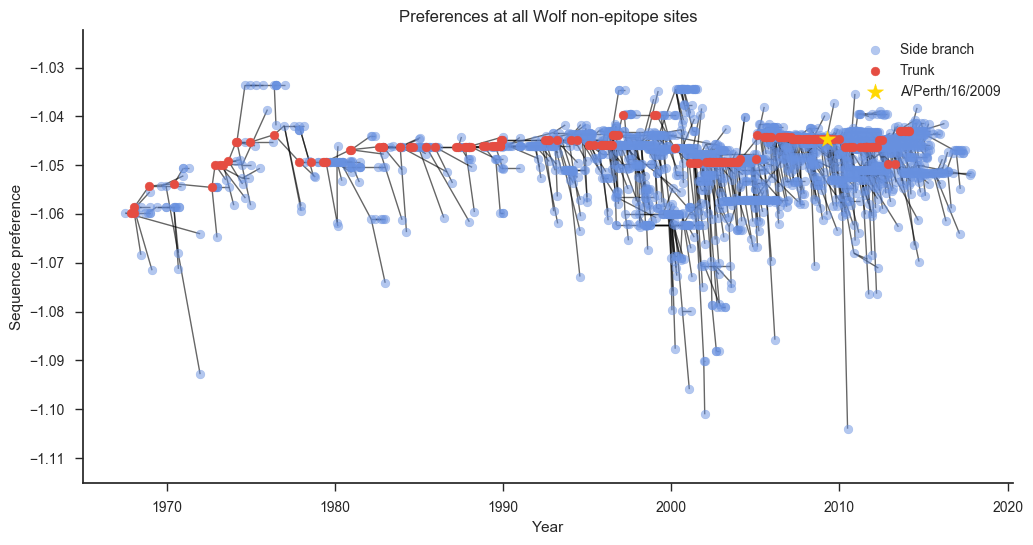

In [136]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference_nonepitope_wolf"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key, 
                     tick_multiple=0.01)
ax.set_title("Preferences at all Wolf non-epitope sites")
# ax.hlines(dms_preference[preference_key], 1968, 2017, color="black", alpha=0.5)
sns.despine(ax=ax)
# plt.savefig('{0}/H3_sequencepref_Wolf_nonepitope.pdf'.format(plotsdir), format='pdf')
plt.show()

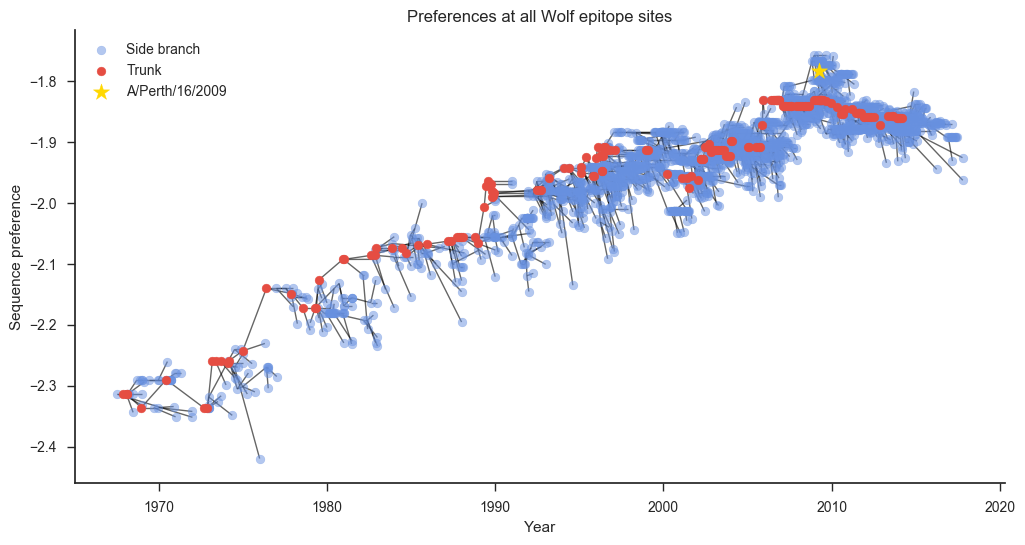

In [135]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference_epitope_wolf"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key, 
                     tick_multiple=0.1)
ax.set_title("Preferences at all Wolf epitope sites")
# ax.hlines(dms_preference[preference_key], 1968, 2017, color="black", alpha=0.5)
sns.despine(ax=ax)
# plt.savefig('{0}/H3_sequencepref_Wolf_epitope.pdf'.format(plotsdir), format='pdf')
plt.show()

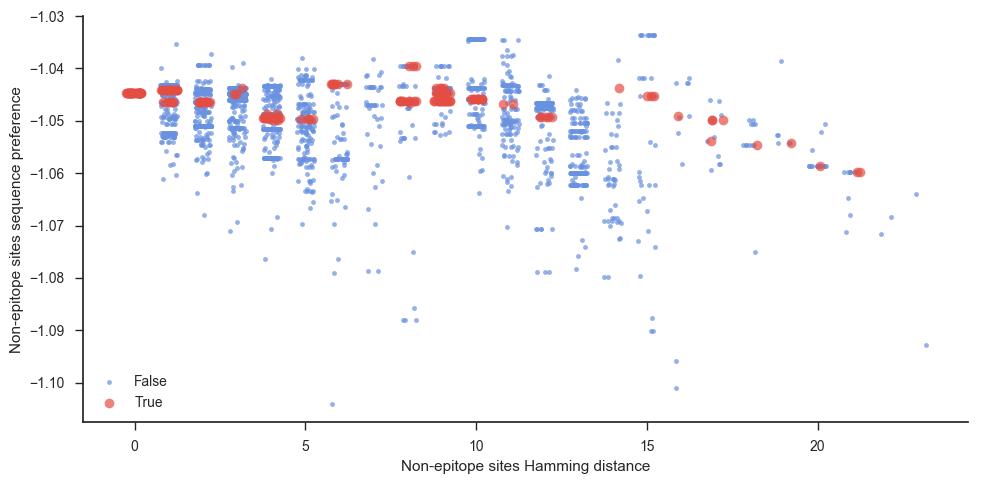

In [201]:
sns.set()
sns.set_style("ticks")
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)

sns.lmplot("hamdist_nonepi_wolf", "preference_nonepitope_wolf", data=preference_df, hue="trunk", 
           fit_reg=False, legend=False, x_jitter=0.25, aspect=2, markers=['.', 'o'], 
           scatter_kws={'alpha':0.7})

sns.despine()
plt.legend(loc = 'lower left')
plt.xlabel('Non-epitope sites Hamming distance')
plt.ylabel('Non-epitope sites sequence preference')

plt.tight_layout()
sns.despine()
# plt.savefig('{0}/hamming_nonepitope_seqpref.pdf'.format(plotsdir), format='pdf')
plt.show()

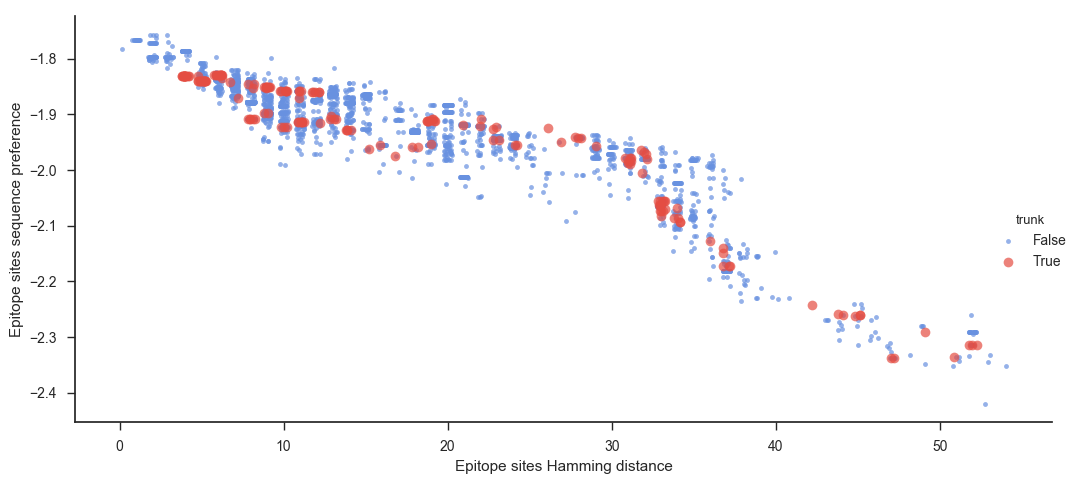

In [204]:
sns.set()
sns.set_style("ticks")
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.lmplot("hamdist_epi_wolf", "preference_epitope_wolf", data=preference_df, hue="trunk", fit_reg=False, 
           x_jitter=0.25, aspect=2, markers=['.', 'o'], scatter_kws={'alpha':0.7})
sns.despine()

plt.xlabel('Epitope sites Hamming distance')
plt.ylabel('Epitope sites sequence preference')

plt.tight_layout()
sns.despine()
# plt.savefig('{0}/hamming_epitope_seqpref.pdf'.format(plotsdir), format='pdf')
plt.show()

## Look at nodes that descend from the trunk after Perth/2009 splits off from the trunk

In [137]:
len(nodes_prior_to_perth)

2227

In [138]:
perth_mrca_resolved_nodes = list(set(list(perth_mrca_trunk.find_clades())) - set(unresolved_nodes))

In [139]:
perth_mrca_preferences_df = pd.DataFrame([{"trunk": node.is_trunk, "preference": node.attr["tol"] / 566}
                                          for node in perth_mrca_resolved_nodes])

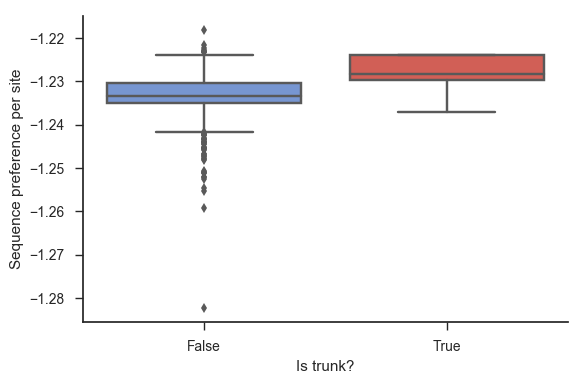

In [140]:
sns.set()
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')

ax = sns.boxplot(x="trunk", y="preference", data=perth_mrca_preferences_df, fliersize=5)
ax.set_xlabel("Is trunk?")
ax.set_ylabel("Sequence preference per site")
sns.despine()

plt.tight_layout()
# plt.savefig('{0}/sequencepref_dist_postPerth2009.pdf'.format(plotsdir), format='pdf')
plt.show()

In [141]:
preference_df = build_frame_for_tree(perth_mrca_trunk)

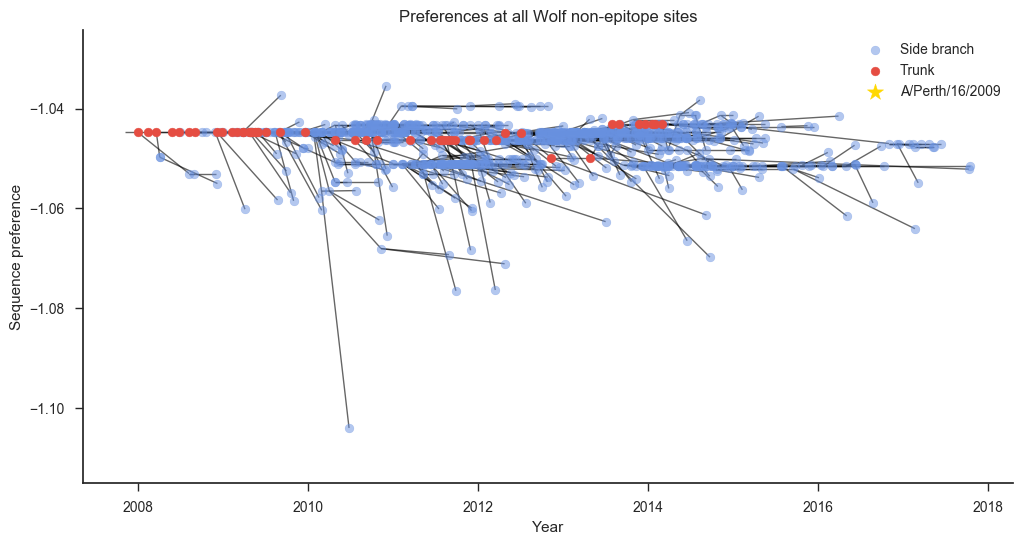

In [143]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference_nonepitope_wolf"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key,
                     tick_multiple=0.02)
ax.set_title("Preferences at all Wolf non-epitope sites")
ax.hlines(dms_preference[preference_key], 1968, 2017, color="black", alpha=0.5)
#ax.set_ylim(-2.4, -1.0)
sns.despine(ax=ax)
# plt.savefig('{0}/sequencepref_nonepi_postPerth2009.pdf'.format(plotsdir), format='pdf')
plt.show()

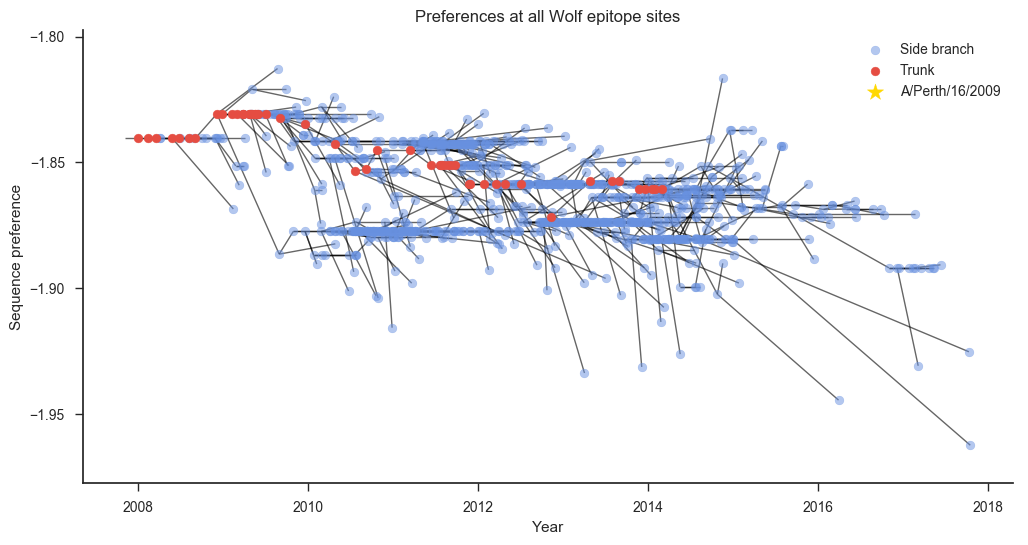

In [145]:
sns.set()
sns.set_style('white')
sns.set_style('ticks')
from matplotlib import gridspec

preference_key = "preference_epitope_wolf"
trunk_preference = preference_df[preference_df["trunk"] == True].copy()
non_trunk_preference = preference_df[(preference_df["trunk"] == False)].copy()
dms_preference = preference_df[preference_df["name"] == "A/Perth/16/2009"]

# Build a list of lines for each preference entry from one node to its parent.
segments = preference_df[preference_df["parent_date"] > 0].apply(
    lambda row: [(row["date"], row[preference_key]), (row["parent_date"], row["parent_%s" % preference_key])],
    axis=1
).values

fig = plt.subplots(figsize=(12, 6), facecolor='w')

gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Plot complete tree.
ax = plt.subplot(gs[0])
plot_preference_tree(ax, segments, trunk_preference, non_trunk_preference, dms_preference, preference_key,
                     tick_multiple=0.05)
ax.set_title("Preferences at all Wolf epitope sites")
ax.hlines(dms_preference[preference_key], 1968, 2017, color="black", alpha=0.5)
#ax.set_ylim(-2.4, -1.0)
sns.despine(ax=ax)
# plt.savefig('{0}/sequencepref_epi_postPerth2009.pdf'.format(plotsdir), format='pdf')
plt.show()

In [146]:
len(perth_mrca_resolved_nodes)

1083

In [147]:
perth_mrca_trunk_path = [node for node in perth_mrca_resolved_nodes
              if node.is_trunk]
len(perth_mrca_trunk_path)

52

In [148]:
# Find all nodes that are not on the trunk. These are
# side branch nodes.
perth_mrca_side_branch_nodes = [node for node in perth_mrca_resolved_nodes
                     if not node.is_trunk and node not in unresolved_nodes]

print ('There are {0} side branch nodes.'.format(len(perth_mrca_side_branch_nodes)))

There are 1031 side branch nodes.


In [149]:
# Save all mutations along the trunk.
perth_mrca_trunk_mutations = collect_mutations_by_nodes(perth_mrca_trunk_path)

# Save all mutations from any side branch node.
perth_mrca_side_branch_mutations = collect_mutations_by_nodes(perth_mrca_side_branch_nodes)

In [150]:
perth_mrca_trunk_muts = PruneMutList(perth_mrca_trunk_mutations)
perth_mrca_side_muts = PruneMutList(perth_mrca_side_branch_mutations)

In [151]:
perth_trunk_epi_muts = [m for m in perth_mrca_trunk_muts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]
perth_side_epi_muts = [m for m in perth_mrca_side_muts if 'HA2' not in m and (m.split(':')[0])[1:-1] in epi_sites]

In [152]:
perth_trunk_nonepi_muts = [m for m in perth_mrca_trunk_muts if m not in perth_trunk_epi_muts]
perth_side_nonepi_muts = [m for m in perth_mrca_side_muts if m not in perth_side_epi_muts]

In [153]:
perth_epi_trunk_muteffects = CalculateAllFitnessEffects(perth_trunk_epi_muts, rescaledavgprefs)
perth_epi_side_muteffects = CalculateAllFitnessEffects(perth_side_epi_muts, rescaledavgprefs)

perth_mrca_trunk_muts_effects = CalculateAllFitnessEffects(perth_trunk_nonepi_muts, rescaledavgprefs)
perth_mrca_side_muts_effects = CalculateAllFitnessEffects(perth_side_nonepi_muts, rescaledavgprefs)

In [154]:
print ('The median of trunk mutational effects = {0}'.format(np.median(perth_mrca_trunk_muts_effects)))
print ('The median of side branch mutational effects = {0}'.format(np.median(perth_mrca_side_muts_effects)))

perthmrca_med_diff = np.log2(np.median(perth_mrca_trunk_muts_effects)) - np.log2(np.median(perth_mrca_side_muts_effects))
perth_epi_med_diff = np.log2(np.median(perth_epi_trunk_muteffects)) - np.log2(np.median(perth_epi_side_muteffects))

print ('The difference between the medians of \
trunk and side branch mutational effects at non-epitope sites = {0}'.format(perthmrca_med_diff))
print ('The difference between the medians of \
trunk and side branch mutational effects at epitope sites = {0}'.format(perth_epi_med_diff))

The median of trunk mutational effects = 1.4601888513543189
The median of side branch mutational effects = 0.5245045490725513
The difference between the medians of trunk and side branch mutational effects at non-epitope sites = 1.4771277794045756
The difference between the medians of trunk and side branch mutational effects at epitope sites = 0.23297048374348617


In [162]:
perthmrca_muteffects = []
perthmrca_muteffects.append([e for e in np.log2(perth_mrca_side_muts_effects)])
perthmrca_muteffects.append([e for e in np.log2(perth_mrca_trunk_muts_effects)])

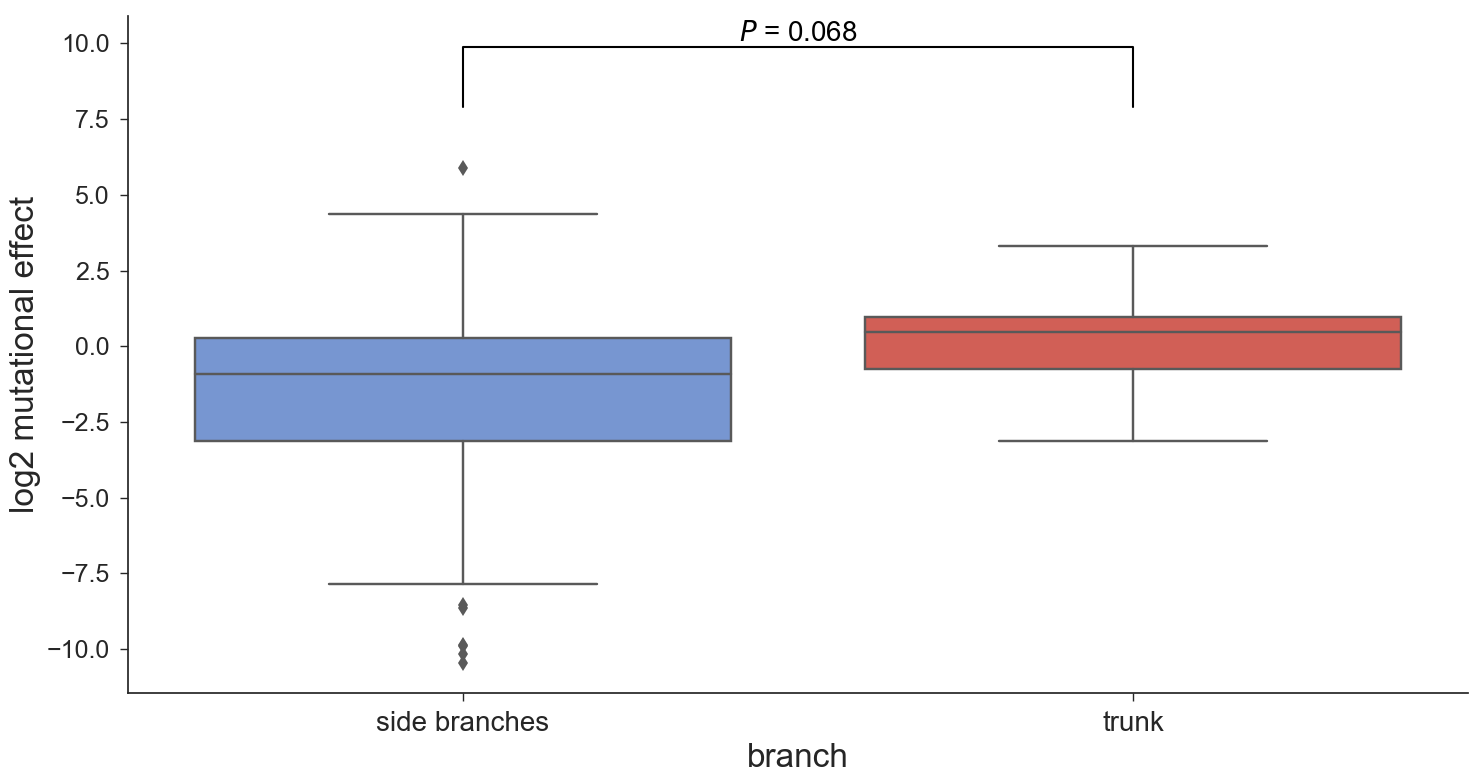

In [164]:
sns.set()
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=perthmrca_muteffects, fliersize=8)
g.set_xticklabels(['side branches','trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

x1, x2 = 0, 1
y, h, col = max(perthmrca_muteffects[0] + perthmrca_muteffects[1]) + 2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "$P$ = 0.068", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/perth_mrca_trunk_sidebr_nonepi.pdf'.format(plotsdir), format='pdf')
plt.show()

In [155]:
perth_epi_muteffects = []
perth_epi_muteffects.append([e for e in np.log2(perth_epi_side_muteffects)])
perth_epi_muteffects.append([e for e in np.log2(perth_epi_trunk_muteffects)])

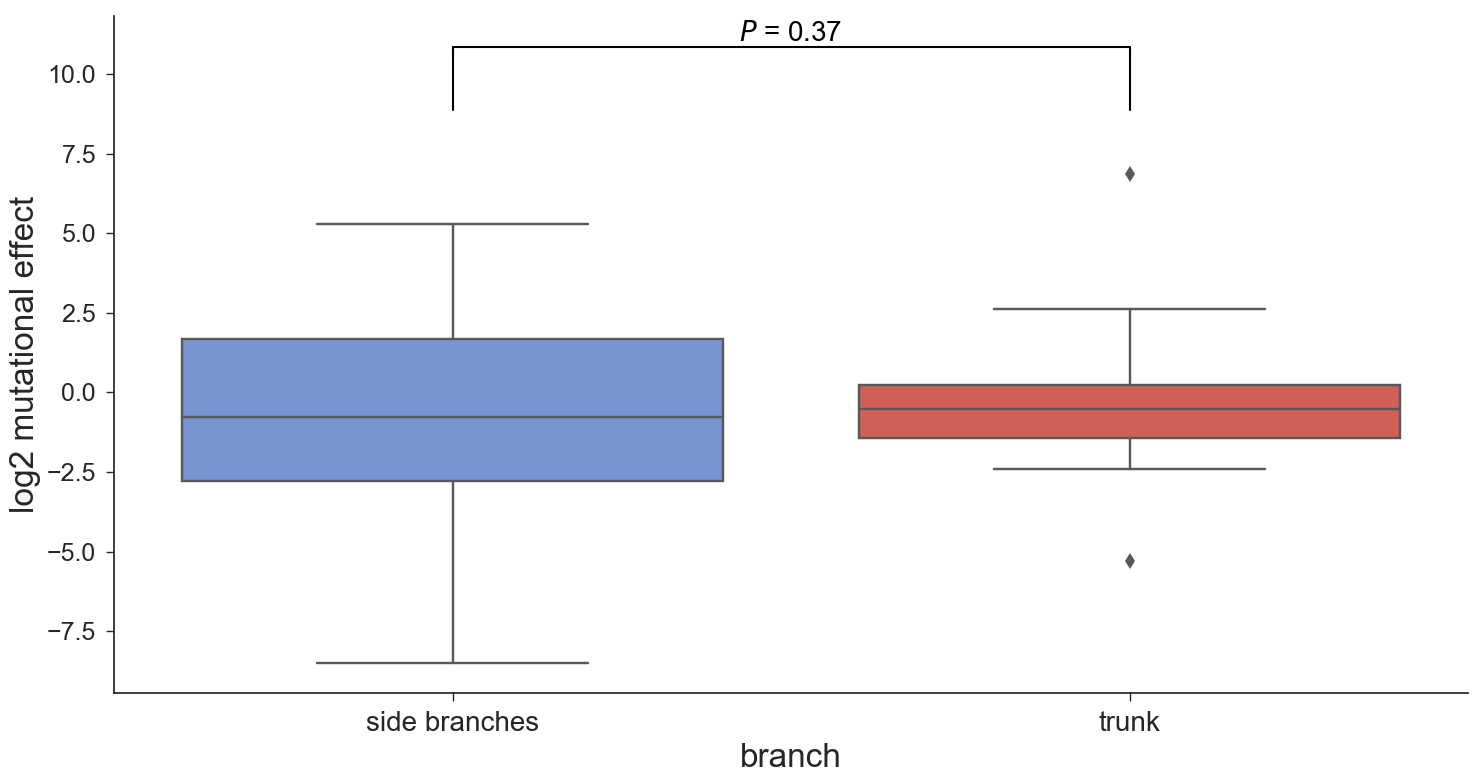

In [165]:
sns.set()
flatui = ['#6891e0', '#e54d42']
sns.color_palette(flatui)
sns.set_palette(flatui)
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=perth_epi_muteffects, fliersize=8)
g.set_xticklabels(['side branches','trunk'])
ax.set_xlabel('branch', fontsize = 24)
ax.set_ylabel('log2 mutational effect', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

x1, x2 = 0, 1
y, h, col = max(perth_epi_muteffects[0] + perth_epi_muteffects[1]) + 2, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "$P$ = 0.37", ha='center', va='bottom', color=col, fontsize = 20)

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/perth_mrca_trunk_sidebr_epi.pdf'.format(plotsdir), format='pdf')
plt.show()

In [157]:
perth_mrca_trunk_parsed = ParseMutListToTuples(perth_trunk_nonepi_muts)
perth_mrca_side_parsed = ParseMutListToTuples(perth_side_nonepi_muts)

perth_epi_trunk_parsed = ParseMutListToTuples(perth_trunk_epi_muts)
perth_epi_side_parsed = ParseMutListToTuples(perth_side_epi_muts)

In [201]:
trunk_sidebr_shuffled = ShufflePrefs('trunk', perth_mrca_trunk_parsed, 
                                     'side_branch', perth_mrca_side_parsed, 
                                     rescaledavgprefs, iterations = num_iter, 
                                     sites=epi_sites, exclude_sites=True)

In [202]:
perth_mrca_shuffleddf = pd.DataFrame.from_dict(trunk_sidebr_shuffled)
perth_mrca_shuffleddf['effectdiff'] = perth_mrca_shuffleddf.trunk - perth_mrca_shuffleddf.side_branch
print ('This is the number of trunk median minus side branch median differences \
that are > {0}:'.format(perthmrca_med_diff))
print (sum(e > perthmrca_med_diff for e in perth_mrca_shuffleddf.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= perthmrca_med_diff for e in perth_mrca_shuffleddf.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch median differences that are greater than > 1.4771277794045756:
684
This is 6.84% of the randomizations.


In [158]:
epi_perth_shuffled = ShufflePrefs('trunk', perth_epi_trunk_parsed, 
                                  'side_branch', perth_epi_side_parsed, 
                                  rescaledavgprefs, iterations = num_iter, 
                                  sites=epi_sites)

In [159]:
perth_epi_shuffleddf = pd.DataFrame.from_dict(epi_perth_shuffled)
perth_epi_shuffleddf['effectdiff'] = perth_epi_shuffleddf.trunk - perth_epi_shuffleddf.side_branch
print ('This is the number of trunk median minus side branch median differences \
that are greater than > {0}:'.format(perth_epi_med_diff))
print (sum(e > perth_epi_med_diff for e in perth_epi_shuffleddf.effectdiff))
print ('This is {0}% of the randomizations.'.format(sum(e >= perth_epi_med_diff for e in perth_epi_shuffleddf.effectdiff)/float(num_iter)*100.0))

This is the number of trunk median minus side branch median differences that are greater than > 0.23297048374348617:
3713
This is 37.13% of the randomizations.
